<a href="https://colab.research.google.com/github/sa-hs/Modelos-de-aprendizaje-estadistico/blob/main/Final_Analisis_PI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelos de aprendizaje estadístico para la detección de fraudes en el seguro de automóviles**

---

---
El objetivo de este trabajo es desarrollar modelos de aprendizaje estadístico capaces de predecir, con la mayor precisión posible, si un siniestro es fraudulento o no. El proyecto se centrará en la implementación y comparación de diversos modelos.


El propósito es determinar cuál de ellos presenta mejor capacidad de clasificación sobre nuevas observaciones. Las metodologías se aplicarán a un conjunto de datos que contiene 32 variables predictoras y una variable objetivo.



**Modelos:**
+ Bosques aleatrios
+ Logistico
+ GBM

**Variantes de smote:**
+ smote ENN
+ smote TL
+ Stable smote

**Métricas:**
+ Accuracy
+ MCC-F1

# **Funciones necesarias**

---



In [ ]:
!pip install feature-engine

In [ ]:
pip install smote-variants

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.metrics import matthews_corrcoef
from feature_engine.encoding import MeanEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import f1_score
from scipy.stats import randint
from sklearn.metrics import precision_recall_curve, auc
import os


# Modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Variantes smote
import smote_variants as sv

## Métrica MCC-F1

In [ ]:
# Graficar la métrica MCC-F1

def mcc_f1_curve(y_true, y_scores, graficar=None):
    thresholds = np.unique(y_scores) # Calcular la curva MCC-F1 para diferentes umbrales.
    mccs, f1s = [], []
    for t in thresholds: # generar predicciones binarias respecto a t quitando  0's
        y_pred = (y_scores >= t).astype(int)
        try:
            mcc = matthews_corrcoef(y_true, y_pred)
        except:
            mcc = 0.0
        try:
            f1 = f1_score(y_true, y_pred)
        except:
            f1 = 0.0
        mccs.append(mcc)
        f1s.append(f1)

    mcc_arr = np.array(mccs)
    f1_arr = np.array(f1s)

    # Normalizar MCC a un rango entre 0 y 1
    mcc_norm = (mcc_arr + 1) / 2

    # Graficar
    if graficar is not None:
      plt.figure(figsize=(10, 10))
      plt.plot(mcc_norm, f1_arr, marker='o', linestyle='-', color='purple', alpha=0.7)
      plt.scatter([1], [1], color='green', label='Perfect performance (1,1)', zorder=5)
      plt.title('MCC-F1 Curve')
      plt.xlabel('Normalized MCC')
      plt.ylabel('F1 Score')
      plt.grid(True)
      plt.legend()
      plt.axis([0, 1, 0, 1])
      plt.gca().set_aspect('equal', adjustable='box')
      plt.show()


    return thresholds, mcc_norm, f1_arr


In [ ]:
#Encontrar el mejor umbral T
def best_threshold(thresholds, mcc_norm, f1_arr):
    dists = np.sqrt((1 - mcc_norm)**2 + (1 - f1_arr)**2)
    best_idx = int(np.argmin(dists))
    return thresholds[best_idx], mcc_norm[best_idx], f1_arr[best_idx]


In [ ]:
# Calcular la métrica MCC-F1 como la distancia promedio desde los puntos
def mcc_f1_metric(mcc_norm, f1_arr, thresholds, W=100):
    mcc_norm = np.array(mcc_norm)
    f1_arr = np.array(f1_arr)
    thresholds = np.array(thresholds)

    # Distancia Euclidiana a (1,1) para cada punto
    distances = np.sqrt((1 - mcc_norm)**2 + (1 - f1_arr)**2)

    # Encontrar índice del mejor punto
    best_idx = np.argmin(distances)
    T_best = thresholds[best_idx]  # Umbral óptimo

    # Dividir en lado izquierdo (L: threshold >= T_best) y derecho (R: threshold < T_best)
    left_mask = thresholds >= T_best
    right_mask = thresholds < T_best

    sides = {'L': left_mask, 'R': right_mask}
    min_x = np.min(mcc_norm)
    max_x = np.max(mcc_norm)
    w = (max_x - min_x) / W

    D_sj_list = []
    for side, mask in sides.items():
        side_mcc = mcc_norm[mask]
        side_f1 = f1_arr[mask]
        side_dist = distances[mask]

        for j in range(W):
            low = min_x + j * w
            high = low + w if j < W - 1 else max_x

            idx = (side_mcc >= low) & (side_mcc < high) if j < W - 1 else (side_mcc >= low) & (side_mcc <= high)
            if np.any(idx):
                D_sj = np.mean(side_dist[idx])  # Ecuación 12
                D_sj_list.append(D_sj)

    # Ecuación 14: Promedio de distancias medias en ambos lados
    D_estrella = np.mean(D_sj_list)

    # Ecuación 15: Normalización final
    MCC_F1 = 1 - (D_estrella / np.sqrt(2))
    return MCC_F1



## Stable SMOTE

---



In [ ]:
# Stable SMOTE
class stable_SMOTE:
    def __init__(self, z_nearest=5, target_ratio=0.5):
        self.z_nearest = z_nearest
        self.target_ratio = target_ratio


    def fit_sample(self, x_dataset):
        x_dataset = pd.DataFrame(x_dataset)

        total_pair = []

        defective_instance = x_dataset[x_dataset["Class"] == 1]
        clean_instance = x_dataset[x_dataset["Class"] == 0]

        defective_number = len(defective_instance)
        clean_number = len(clean_instance)
        target_defect_ratio = 0.5
        need_number = int((target_defect_ratio * len(x_dataset) - defective_number) / (1 - target_defect_ratio))

        print(f"Número de instancias minoritarias necesarias: {need_number}")

        if need_number <= 0:
            print("No se necesitan instancias sintéticas. ")
            return x_dataset # Devolver el dataset original en lugar de False


        generated_dataset = []
        number_on_each_instance = need_number / defective_number
        total_pair = []

        rround = number_on_each_instance / self.z_nearest

        while rround >= 1:
            for index, row in defective_instance.iterrows():
                temp_defective_instance = defective_instance.copy(deep=True)
                subtraction = row - temp_defective_instance
                square = subtraction ** 2
                row_sum = square.apply(lambda s: s.sum(), axis=1)
                distance = row_sum ** 0.5
                temp_defective_instance["distance"] = distance
                temp_defective_instance = temp_defective_instance.sort_values(by="distance", ascending=True)
                neighbors = temp_defective_instance[1:self.z_nearest + 1]
                for a, r in neighbors.iterrows():
                    selected_pair = [index, a]
                    selected_pair.sort()
                    total_pair.append(selected_pair)
            rround = rround - 1

        need_number1 = need_number - len(total_pair)
        number_on_each_instance = need_number1 / defective_number

        for index, row in defective_instance.iterrows():
            temp_defective_instance = defective_instance.copy(deep=True)
            subtraction = row - temp_defective_instance
            square = subtraction ** 2
            row_sum = square.apply(lambda s: s.sum(), axis=1)
            distance = row_sum ** 0.5
            temp_defective_instance["distance"] = distance
            temp_defective_instance = temp_defective_instance.sort_values(by="distance", ascending=True)
            neighbors = temp_defective_instance[1:self.z_nearest + 1]
            neighbors = neighbors.sort_values(by="distance", ascending=False)
            target_sample_instance = neighbors[0: int(number_on_each_instance)]
            target_sample_instance = target_sample_instance.drop(columns="distance")

            for a, r in target_sample_instance.iterrows():
                selected_pair = [index, a]
                selected_pair.sort()
                total_pair.append(selected_pair)

        temp_defective_instance = defective_instance.copy(deep=True)
        residue_number = need_number - len(total_pair)
        if residue_number > 0:
            residue_defective_instance = temp_defective_instance.sample(n=residue_number)

            for index, row in residue_defective_instance.iterrows():
                temp_defective_instance = defective_instance.copy(deep=True)
                subtraction = row - temp_defective_instance
                square = subtraction ** 2
                row_sum = square.apply(lambda s: s.sum(), axis=1)
                distance = row_sum ** 0.5
                temp_defective_instance["distance"] = distance
                temp_defective_instance = temp_defective_instance.sort_values(by="distance", ascending=True)
                neighbors = temp_defective_instance[1:self.z_nearest + 1]
                target_sample_instance = neighbors[-1:]

                for a in target_sample_instance.index:
                    selected_pair = [index, a]
                    selected_pair.sort()
                    total_pair.append(selected_pair)

        total_pair_tuple = [tuple(l) for l in total_pair]
        result = Counter(total_pair_tuple)
        result_number = len(result)
        result_keys = result.keys()
        result_values = result.values()

        for f in range(result_number):
            current_pair = list(result_keys)[f]
            row1_index = current_pair[0]
            row2_index = current_pair[1]
            row1 = defective_instance.loc[row1_index]
            row2 = defective_instance.loc[row2_index]
            generated_num = list(result_values)[f]
            generated_instances = np.linspace(row1, row2, generated_num + 2)
            generated_instances = generated_instances[1:-1]
            generated_instances = generated_instances.tolist()
            for w in generated_instances:
                generated_dataset.append(w)

        final_generated_dataset = pd.DataFrame(data=generated_dataset, columns=clean_instance.columns)
        final_generated_dataset = final_generated_dataset.astype(clean_instance.dtypes.to_dict())

        result = pd.concat([clean_instance, defective_instance, final_generated_dataset], axis=0)
        result.reset_index(drop=True, inplace=True)
        return result

##Validación Cruzada con SMOTE

---



In [ ]:
def aplicar_validacion_cruzada_smote(df_reduced, smote_type, modelo_type, n_splits=10):
    features = [col for col in df_reduced.columns if col != 'Class']
    X = df_reduced[features].copy()
    y = df_reduced['Class'].copy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()

    # Selección del modelo
    if modelo_type == 'rf':
        modelo = RandomForestClassifier(random_state=42)
    elif modelo_type == 'gbm':
        modelo = GradientBoostingClassifier(random_state=42)
    elif modelo_type == 'logit':
        modelo = LogisticRegression(max_iter=100, solver='liblinear', random_state=42)
    else:
        raise ValueError(f"Modelo '{modelo_type}' no reconocido. Usa 'rf', 'gbm' o 'logit'.")


    scores_unbalanced = [] #NUEVO
    mcc_scores_unbalanced =[] #NUEVO
    scores = []
    mcc_scores =[]
    mcc_f1_scores = []
    umbral = []
    confusion_elements = []
    scores_50 = []
    mcc_scores_50 = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        print(f"\n=== Fold {fold} ===")

        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

        # Scaling train and test  #NUEVO
        X_train_scaled = pd.DataFrame(    #NUEVO
            scaler.fit_transform(X_train),   #NUEVO
            columns=features,  #NUEVO
            # Keep the index as it might be useful for later operations,  #NUEVO
            # although after SMOTE the index will be new  #NUEVO
            index=X_train.index  #NUEVO
        ) #NUEVO

        X_test_scaled = pd.DataFrame( #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)
            scaler.transform(X_test), #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)
            columns=features, #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)
            index=X_test.index #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)
        ) #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)

        #Fitting the model with an unbalanced training data
        modelo.fit(X_train_scaled, y_train) #NUEVO
        y_prob_unbalanced = modelo.predict_proba(X_test_scaled)[:, 1] #Obtener probabilidades de la clase positiva #NUEVO
        y_pred_unbalanced_50 = (y_prob_unbalanced >= 0.5).astype(int) #NUEVO
        accuracy_unbalanced_50 = accuracy_score(y_test, y_pred_unbalanced_50 ) #NUEVO
        mcc_unbalanced_50 = matthews_corrcoef(y_test, y_pred_unbalanced_50 ) #NUEVO


        # Convert to NumPy arrays before applying SMOTE
        X_train_np = X_train.values
        y_train_np = y_train.values

        # Selección de SMOTE
        if smote_type == 'sstable':
            # Stable SMOTE implementation takes pandas DataFrame, so keep as is
            train_data = X_train.copy()
            train_data['Class'] = y_train
            smote = stable_SMOTE(z_nearest=5)
            balanced_train_data = smote.fit_sample(train_data)
            X_train_balanced = balanced_train_data[features].copy()
            y_train_balanced = balanced_train_data['Class'].copy()
        elif smote_type == 'smoteipf':
            smote = sv.SMOTE_IPF(random_state=42)
            X_train_balanced_np, y_train_balanced_np = smote.fit_resample(X_train_np, y_train_np)
            X_train_balanced = pd.DataFrame(X_train_balanced_np, columns=features)
            y_train_balanced = pd.Series(y_train_balanced_np, name='Class')
        elif smote_type == 'smotetl':
             smote = sv.SMOTE_TomekLinks(random_state=42)
             # Pass NumPy arrays to smote_variants
             X_train_balanced_np, y_train_balanced_np = smote.fit_resample(X_train_np, y_train_np)
             # Convert back to DataFrame after sampling
             X_train_balanced = pd.DataFrame(X_train_balanced_np, columns=features)
             y_train_balanced = pd.Series(y_train_balanced_np, name='Class')
        else:
            raise ValueError(f"SMOTE tipo '{smote_type}' no reconocido. Usa 'sstable', 'smoteenn' o 'smotetl'.")

        print(f"Distribución antes de SMOTE: {y_train.value_counts().to_dict()}")
        print(f"Distribución después de SMOTE: {y_train_balanced.value_counts().to_dict()}")

        # Ensure data types are float64
        X_train_balanced = X_train_balanced.astype('float64')
        X_test = X_test.astype('float64')

        # Scaling requires DataFrames with column names for clarity and robustness
        X_train_balanced_scaled = pd.DataFrame(
            scaler.fit_transform(X_train_balanced),
            columns=features,
            # Keep the index as it might be useful for later operations,
            # although after SMOTE the index will be new
            index=X_train_balanced.index
        )

        #Fitting after balanced data
        modelo.fit(X_train_balanced_scaled, y_train_balanced)

        if hasattr(modelo, 'predict_proba'):
            y_prob = modelo.predict_proba(X_test_scaled)[:, 1] #Obtener probabilidades de la clase positiva
        else:
            y_prob = modelo.decision_function(X_test_scaled)
            # Check if decision_function returned a scalar before normalizing
            if np.ndim(y_prob) == 0:
                 y_prob = np.array([y_prob])
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # Normalizar

        # Asegurar que y_test es un arreglo NumPy
        thresholds, mcc_norm, f1_arr = mcc_f1_curve(y_test.values, y_prob)

        # Pasar también thresholds a la función mcc_f1_metric
        mcc_f1_score = mcc_f1_metric(mcc_norm, f1_arr, thresholds, W=100)

        # Obtener el umbral óptimo
        umbral_optimo, mcc_opt, f1_opt = best_threshold(thresholds, mcc_norm, f1_arr)

        # Generar las predicciones con el nuevo umbral
        y_pred_nuevo_umbral = (y_prob >= umbral_optimo).astype(int)

        # Generar las predicciones con umbral 50%
        y_pred_50 = (y_prob >= 0.5).astype(int)
        accuracy_50 = accuracy_score(y_test, y_pred_50 )
        mcc_50 = matthews_corrcoef(y_test, y_pred_50 )


        # Predicción con umbral ótimo
        y_pred_nuevo_umbral = (y_prob >= umbral_optimo).astype(int)

        cm = confusion_matrix(y_test, y_pred_nuevo_umbral)
        print("Matriz de confusión (Umbral óptimo):") #MODIFICADO
        print(cm)

        tn, fp, fn, tp = cm.ravel()
        confusion_elements.append((tn, fp, fn, tp))

        accuracy = accuracy_score(y_test, y_pred_nuevo_umbral)
        mcc=matthews_corrcoef(y_test, y_pred_nuevo_umbral)

        print(f"Exactitud (datos de entrenamiento desbalanceados) en Fold {fold}: {accuracy_unbalanced_50:.4f}") #NUEVO
        print(f"MCC (datos de entrenamiento desbalanceados) en Fold {fold}: {mcc_unbalanced_50:.4f}") #NUEVO

        print(f"Exactitud (SMOTE con umbral 50%) en Fold {fold}: {accuracy_50:.4f}") #SE MODIFICÓ
        print(f"MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold {fold}: {mcc_50:.4f}") #SE MODIFICÓ

        print(f"Exactitud (SMOTE con umbral óptimo) Fold {fold}: {accuracy:.4f}") #SE MODIFICÓ
        print(f"MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold {fold}: {mcc:.4f}") #SE MODIFICÓ


        print(f"MCC-F1 score (Fold {fold}): {mcc_f1_score:.4f}")
        print(f"Umbral óptimo: {umbral_optimo:.4f} — MCC(Normalizado): {mcc_opt:.4f}, F1: {f1_opt:.4f}") #SE MODIFICÓ

        scores_unbalanced.append(accuracy_unbalanced_50) #NUEVO
        mcc_scores_unbalanced.append(mcc_unbalanced_50) #NUEVO
        scores.append(accuracy)
        mcc_f1_scores.append(mcc_f1_score)
        mcc_scores.append(mcc)
        umbral.append(umbral_optimo)
        scores_50.append(accuracy_50)
        mcc_scores_50.append(mcc_50)

    print("\nResultados Finales:")
    if scores:
        print(f"Exactitud media (datos de entrenamiento desbalanceados) : {np.mean(scores_unbalanced):.4f} ± {np.std(scores_unbalanced):.4f}") #NUEVO
        print(f"MCC medio (datos de entrenamiento desbalanceados) : {np.mean(mcc_scores_unbalanced):.4f} ± {np.std(mcc_scores_unbalanced):.4f}") #NUEVO
        print(f"Exactitud media (SMOTE con umbral 50%) : {np.mean(scores_50):.4f} ± {np.std(scores_50):.4f}") #SE MODIFICÓ
        print(f"MCC medio (SMOTE con umbral 50%) : {np.mean(mcc_scores_50):.4f} ± {np.std(mcc_scores_50):.4f}") #SE MODIFICÓ
        print(f"Exactitud media (SMOTE con umbral óptimo) : {np.mean(scores):.4f} ± {np.std(scores):.4f}") #SE MODIFICÓ
        print(f"MCC medio (SMOTE con umbral óptimo) : {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}") #SE MODIFICÓ
        print(f"MCC-F1 medio: {np.mean(mcc_f1_scores):.4f} ± {np.std(mcc_f1_scores):.4f}")
        print(f"Mejor umbral: {np.mean(umbral):.4f}")
    else:
        print("No se pudo completar la validación cruzada.")

    return scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  #SE MODIFICÓ

## Validación Cruzada sin SMOTE
---



In [ ]:
#Validación cruzada sin smote
def aplicar_validacion_cruzada(df_reduced, modelo_type, n_splits=10):
    features = [col for col in df_reduced.columns if col != 'Class']
    X = df_reduced[features].copy()
    y = df_reduced['Class'].copy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()

    # Selección del modelo
    if modelo_type == 'rf':
        modelo = RandomForestClassifier(random_state=42)
    elif modelo_type == 'gbm':
        modelo = GradientBoostingClassifier(random_state=42)
    elif modelo_type == 'logit':
        modelo = LogisticRegression(solver='liblinear', random_state=42)
    else:
        raise ValueError(f"Modelo '{modelo_type}' no reconocido. Usa 'rf', 'gbm' o 'logit'.")

    scores = []
    mcc_scores =[]
    mcc_f1_scores = []
    umbral = []
    confusion_elements = []
    scores_50 = []
    mcc_scores_50 = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        print(f"\n=== Fold {fold} ===")

        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

        X_train = X_train.astype('float64')
        X_test = X_test.astype('float64')

        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train),
            columns=features,
            index=X_train.index
        )

        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test),
            columns=features,
            index=X_test.index
        )

        modelo.fit(X_train_scaled, y_train)

        if hasattr(modelo, 'predict_proba'):
            y_prob = modelo.predict_proba(X_test_scaled)[:, 1]
        else:
            y_prob = modelo.decision_function(X_test_scaled)
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # Normalización

        # Asegurar que y_test es un arreglo NumPy
        thresholds, mcc_norm, f1_arr = mcc_f1_curve(y_test.values, y_prob)

        # Pasar también thresholds a la función mcc_f1_metric
        mcc_f1_score = mcc_f1_metric(mcc_norm, f1_arr, thresholds, W=100)

        # Obtener el umbral óptimo
        umbral_optimo, mcc_opt, f1_opt = best_threshold(thresholds, mcc_norm, f1_arr)

        # Generar las predicciones con el umbral óptimo
        y_pred_nuevo_umbral = (y_prob >= umbral_optimo).astype(int)

        # Generar las predicciones con umbral 50%
        y_pred_50 = (y_prob >= 0.5).astype(int)
        accuracy_50 = accuracy_score(y_test, y_pred_50 )
        mcc_50 = matthews_corrcoef(y_test, y_pred_50 )

        cm = confusion_matrix(y_test, y_pred_nuevo_umbral)
        print("Matriz de confusión (Umbral óptimo):") #MODIFICADO
        print(cm)

        tn, fp, fn, tp = cm.ravel()
        confusion_elements.append((tn, fp, fn, tp))

        accuracy = accuracy_score(y_test, y_pred_nuevo_umbral)

        mcc=matthews_corrcoef(y_test, y_pred_nuevo_umbral)

        print(f"Exactitud (con umbral 50%) en Fold {fold}: {accuracy_50:.4f}") #NUEVO
        print(f"MCC (con umbral 50%) en Fold {fold}: {mcc_50:.4f}") #NUEVO

        print(f"Exactitud (con umbral óptimo) Fold {fold}: {accuracy:.4f}") #SE MODIFICÓ
        print(f"MCC ( con umbral óptimo)en Fold {fold}: {mcc:.4f}") #SE MODIFICÓ

        print(f"MCC-F1 score (Fold {fold}): {mcc_f1_score:.4f}")
        print(f"Umbral óptimo: {umbral_optimo:.4f} — MCC(Normalizado): {mcc_opt:.4f}, F1: {f1_opt:.4f}") #SE MODIFICÓ


        scores.append(accuracy)
        mcc_f1_scores.append(mcc_f1_score)
        mcc_scores.append(mcc)
        umbral.append(umbral_optimo)
        scores_50.append(accuracy_50)
        mcc_scores_50.append(mcc_50)

    print("\nResultados Finales:")
    if scores:
        print(f"Exactitud media (con umbral 50%) : {np.mean(scores_50):.4f} ± {np.std(scores_50):.4f}") #SE MODIFICÓ
        print(f"MCC medio (con umbral 50%) : {np.mean(mcc_scores_50):.4f} ± {np.std(mcc_scores_50):.4f}") #SE MODIFICÓ
        print(f"Exactitud media (con umbral óptimo) : {np.mean(scores):.4f} ± {np.std(scores):.4f}") #SE MODIFICÓ
        print(f"MCC medio (con umbral óptimo) : {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}") #SE MODIFICÓ
        print(f"MCC-F1 medio: {np.mean(mcc_f1_scores):.4f} ± {np.std(mcc_f1_scores):.4f}")
        print(f"Mejor umbral: {np.mean(umbral):.4f}")

    else:
        print("No se pudo completar la validación cruzada.")

    return scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50

## Función para guardar los resultados en un archivo csv

In [ ]:
def guardar_resultados(nombre_archivo, modelo, smote,  exactitud_50, mcc_50, umbral,
                       mcc_f1_scores, exactitud_opt, mcc_opt,  confusion_elements):

    # Calcular promedios de los elementos de la matriz de confusión
    tn_mean = np.mean([x[0] for x in confusion_elements])
    fp_mean = np.mean([x[1] for x in confusion_elements])
    fn_mean = np.mean([x[2] for x in confusion_elements])
    tp_mean = np.mean([x[3] for x in confusion_elements])

    resultados_df = pd.DataFrame({

        "Modelo": [modelo],
        "SMOTE": [smote],

        "Exactitud_50": [np.mean(exactitud_50)],
        "MCC_50": [np.mean(mcc_50)],

        "Umbral": [np.mean(umbral)],
        "MCC-F1": [np.mean(mcc_f1_scores)],

        "Exactitud_opt": [np.mean(exactitud_opt)],
        "MCC_opt": [np.mean(mcc_opt)],

        "TN_Medio": [tn_mean],
        "FP_Medio": [fp_mean],
        "FN_Medio": [fn_mean],
        "TP_Medio": [tp_mean],
    })

    resultados_df = resultados_df.round(4)

    if os.path.exists(nombre_archivo):
        resultados_existentes = pd.read_csv(nombre_archivo)
        resultados_final = pd.concat([resultados_existentes, resultados_df], ignore_index=True)
    else:
        resultados_final = resultados_df

    resultados_final.to_csv(nombre_archivo, index=False)
    print(f"Resultados guardados en {nombre_archivo}")

In [ ]:
def guardar_resultados_smote(nombre_archivo, modelo, smote, exactitud_sin_balance, mcc_sin_balance, exactitud_SMOTE_50, mcc_SMOTE_50, umbral,
                       mcc_f1_scores, exactitud_SMOTE_opt, mcc_SMOTE_opt,  confusion_elements):

    # Calcular promedios de los elementos de la matriz de confusión
    tn_mean = np.mean([x[0] for x in confusion_elements])
    fp_mean = np.mean([x[1] for x in confusion_elements])
    fn_mean = np.mean([x[2] for x in confusion_elements])
    tp_mean = np.mean([x[3] for x in confusion_elements])

    resultados_df = pd.DataFrame({
        "Modelo": [modelo],
        "SMOTE": [smote],

        "Exactitud_Sin_Balance": [np.mean(exactitud_sin_balance)],
        "MCC_Sin_Balance": [np.mean(mcc_sin_balance)],

        "Exactitud_SMOTE_50": [np.mean(exactitud_SMOTE_50)],
        "MCC_SMOTE_50": [np.mean(mcc_SMOTE_50)],

        "Umbral": [np.mean(umbral)],
        "MCC-F1": [np.mean(mcc_f1_scores)],

        "Exactitud_SMOTE_opt": [np.mean(exactitud_SMOTE_opt)],
        "MCC_SMOTE_opt": [np.mean(mcc_SMOTE_opt)],

        "TN_Medio": [tn_mean],
        "FP_Medio": [fp_mean],
        "FN_Medio": [fn_mean],
        "TP_Medio": [tp_mean],
    })

    resultados_df = resultados_df.round(4)

    if os.path.exists(nombre_archivo):
        resultados_existentes = pd.read_csv(nombre_archivo)
        resultados_final = pd.concat([resultados_existentes, resultados_df], ignore_index=True)
    else:
        resultados_final = resultados_df

    resultados_final.to_csv(nombre_archivo, index=False)
    print(f"Resultados guardados en {nombre_archivo}")

# **Preprocesamiento de los datos**

El preprocesamiento de los datos para que estén listos para su modelación incluye los siguientes pasos:



1.   Importación de las bases.
2.   Exploración preliminar de la información.
3.   Tratamiento de datos faltantes.
4.   Análisis univariado de la respuesta y análisis bivariado respecto a los predictores.
5.   Ingeniería y transformación de variables.
6.   Eliminación de algunas variables predictoras.
7.   Análisis de datos atípicos.
8.   Generación de conjunto de entrenamiento y validación

---


## 1. Importación de la base de datos

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)


Mounted at /content/drive/


In [ ]:
datos_seguros = '/content/drive/MyDrive/Colab Notebooks/Proy Investigación/fraud_oracle.csv'

df_fraude = pd.read_csv(datos_seguros)

df_fraude

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils


## 2. Exploración preliminar de la información

---

Una vez cargados lo datos es necesario hacer una inspección inicial para conocer características de la base.

In [ ]:
nombre_columnas = df_fraude.columns
nombre_columnas

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

In [ ]:
df_fraude.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [ ]:
df_fraude.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


In [ ]:
df_fraude['FraudFound_P'].value_counts()

,count
FraudFound_P,
0,14497
1,923


In [ ]:
# Seleccionar columnas de tipo 'object'
df_columnas_object = df_fraude.select_dtypes(include='object')

# Obtener el número de valores únicos para cada columna tipo object
df_resumen = df_columnas_object.nunique().reset_index()
df_resumen.columns = ['Variable', 'Valores Únicos']

# Mostrar el resumen
print(df_resumen)

                Variable  Valores Únicos
0                  Month              12
1              DayOfWeek               7
2                   Make              19
3           AccidentArea               2
4       DayOfWeekClaimed               8
5           MonthClaimed              13
6                    Sex               2
7          MaritalStatus               4
8                  Fault               2
9             PolicyType               9
10       VehicleCategory               3
11          VehiclePrice               6
12  Days_Policy_Accident               5
13     Days_Policy_Claim               4
14    PastNumberOfClaims               4
15          AgeOfVehicle               8
16     AgeOfPolicyHolder               9
17     PoliceReportFiled               2
18        WitnessPresent               2
19             AgentType               2
20   NumberOfSuppliments               4
21   AddressChange_Claim               5
22          NumberOfCars               5
23            Ba

## 3. Tratamiento de datos  faltantes

---



In [ ]:
df_fraude.isnull().sum()

,0
Month,0
WeekOfMonth,0
DayOfWeek,0
Make,0
AccidentArea,0
DayOfWeekClaimed,0
MonthClaimed,0
WeekOfMonthClaimed,0
Sex,0
MaritalStatus,0


Ya que no se encuentran datos faltantes, procederemos con el preprocesamiento de los datos.

## 4. Anális de la respuesta y su relación con cada predictor

---



In [ ]:
col_numericas=list(df_fraude._get_numeric_data().columns)
col_numericas

['WeekOfMonth',
 'WeekOfMonthClaimed',
 'Age',
 'FraudFound_P',
 'PolicyNumber',
 'RepNumber',
 'Deductible',
 'DriverRating',
 'Year']

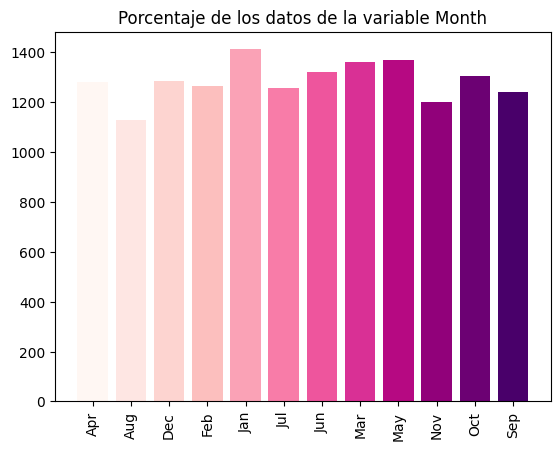

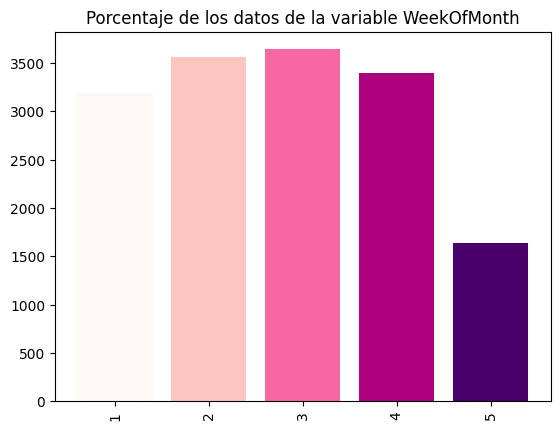

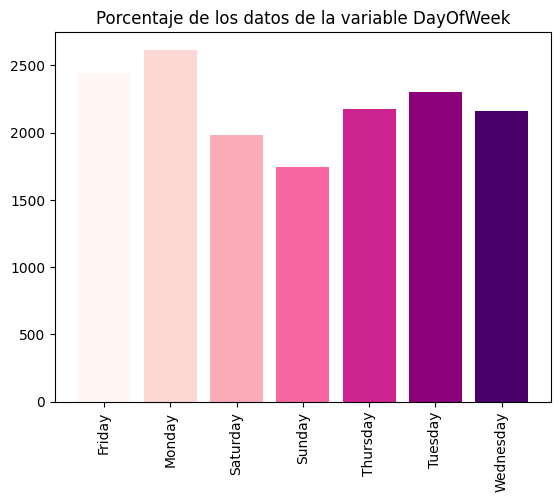

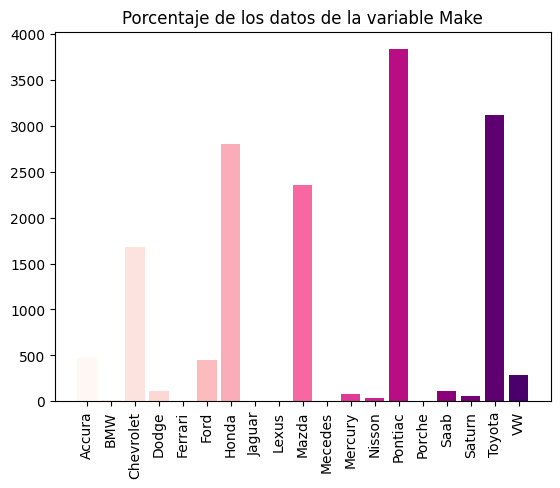

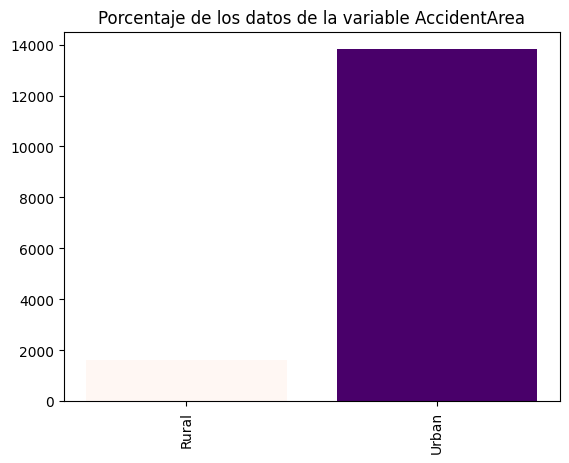

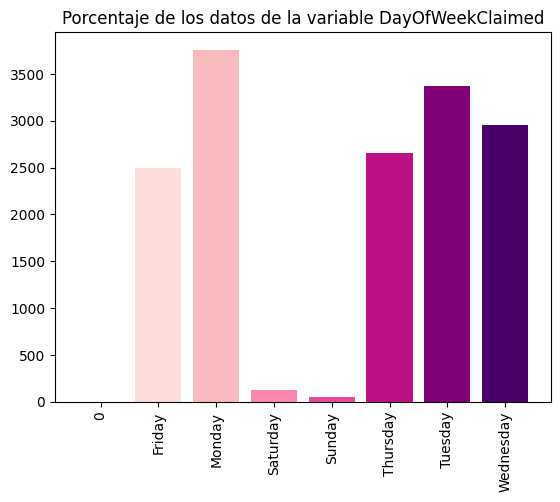

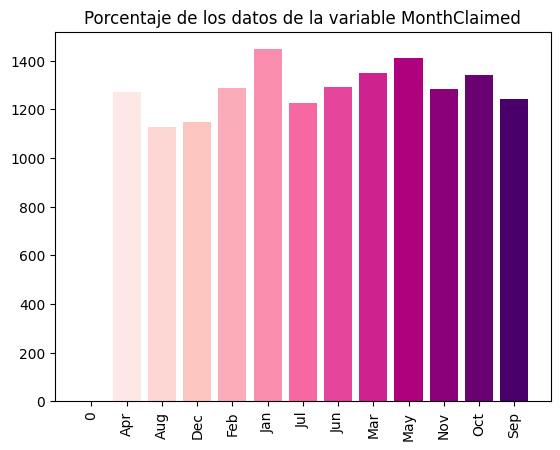

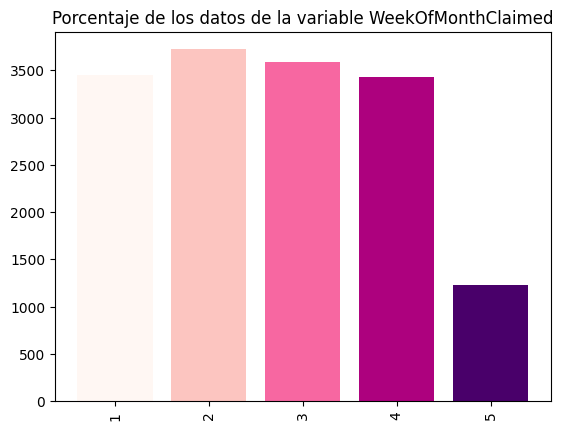

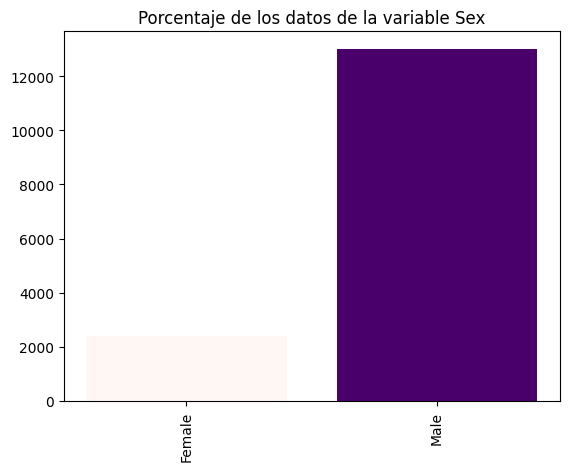

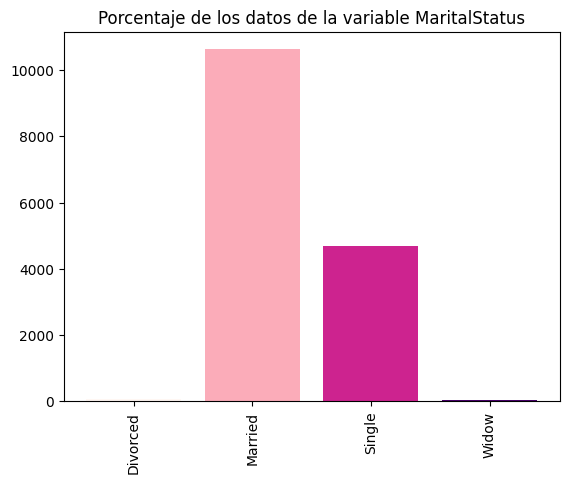

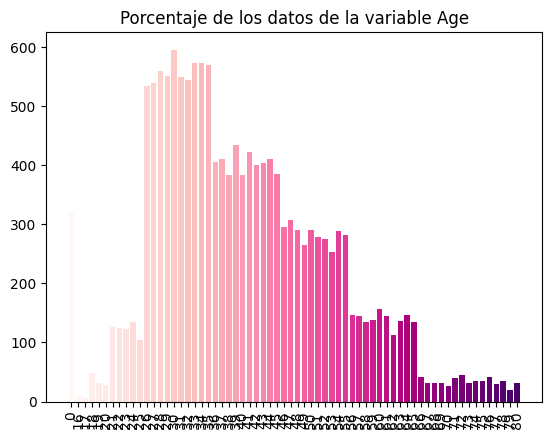

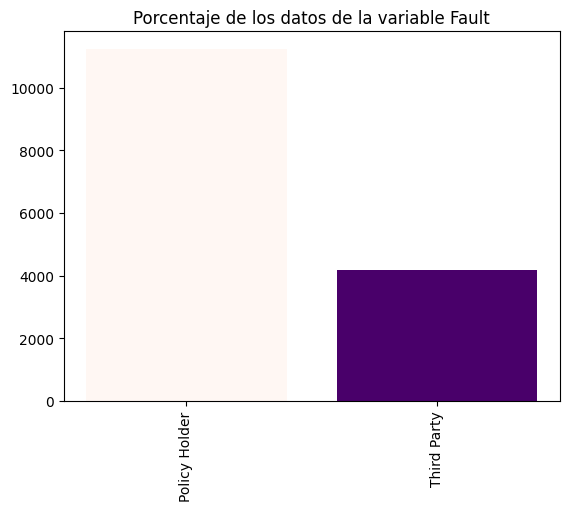

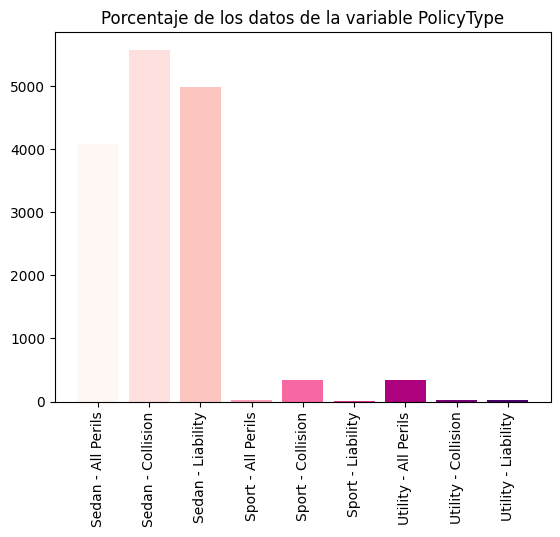

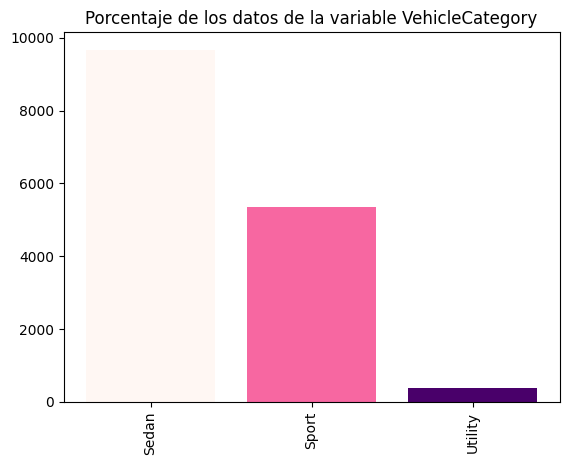

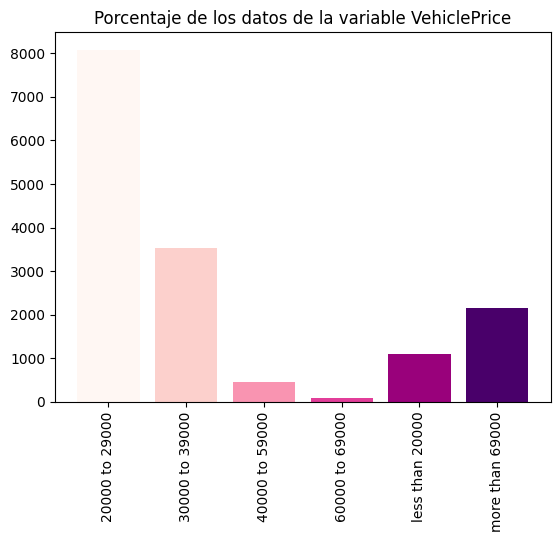

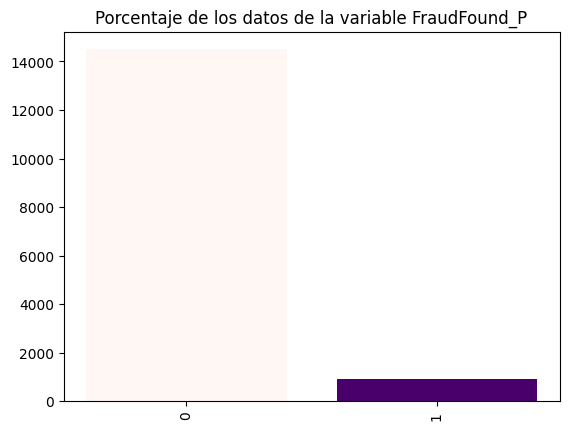

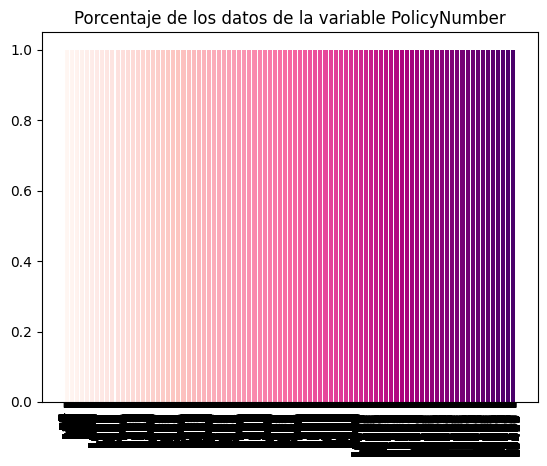

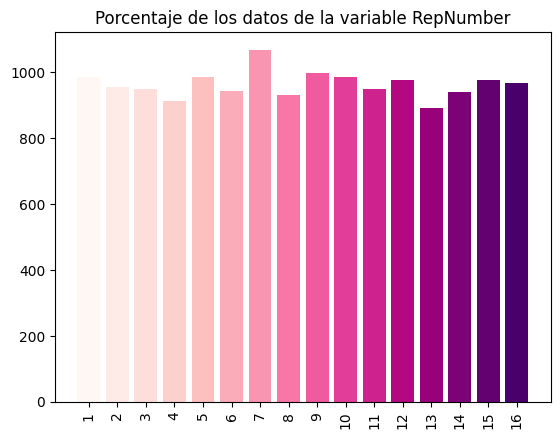

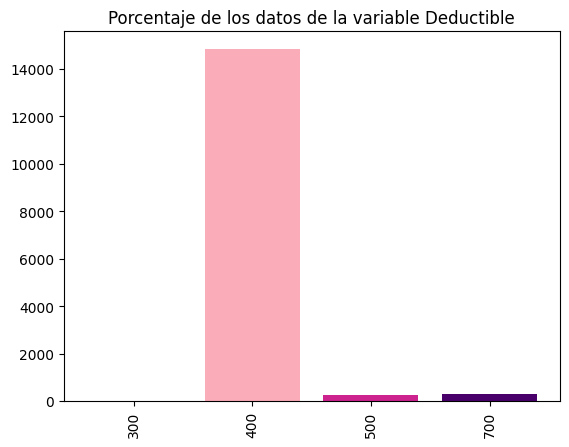

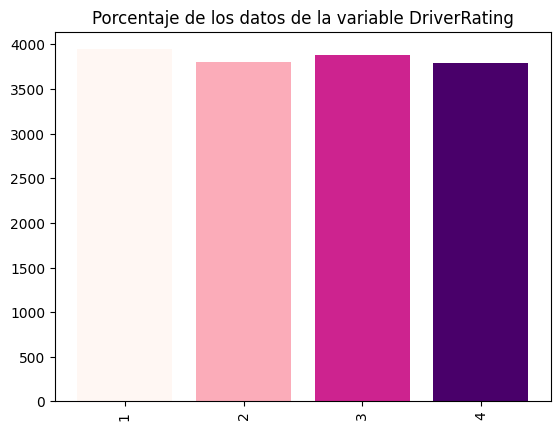

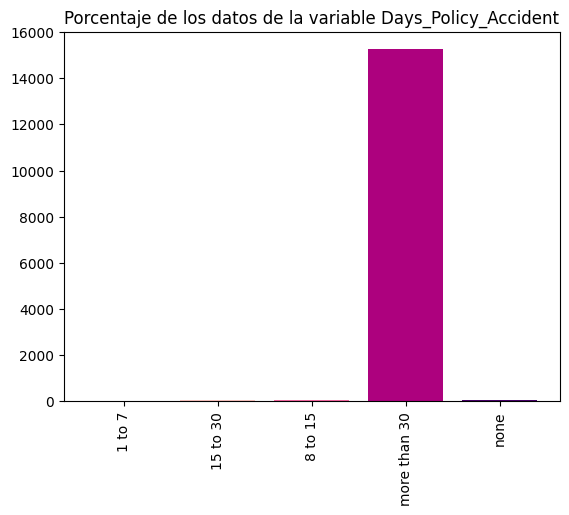

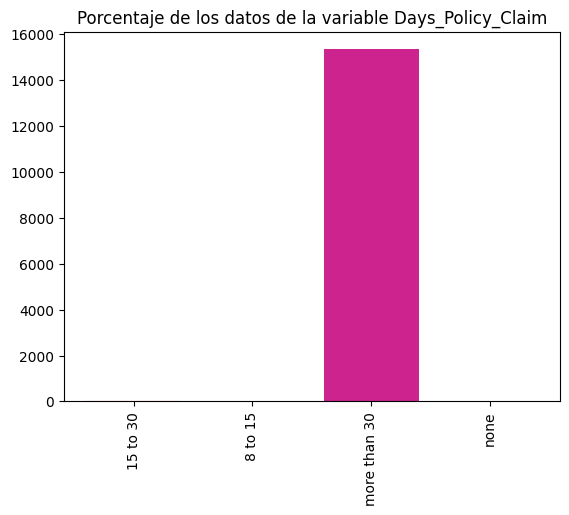

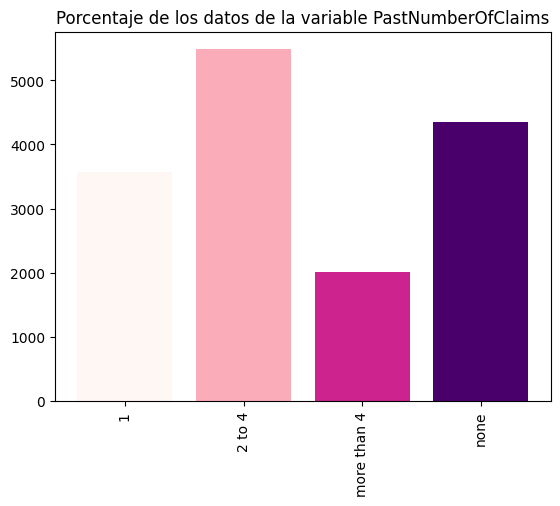

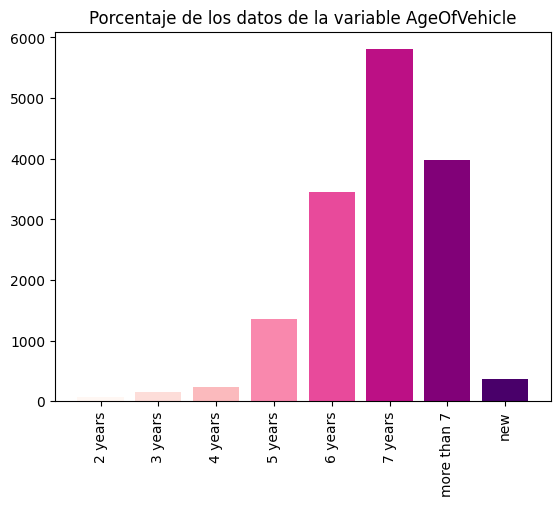

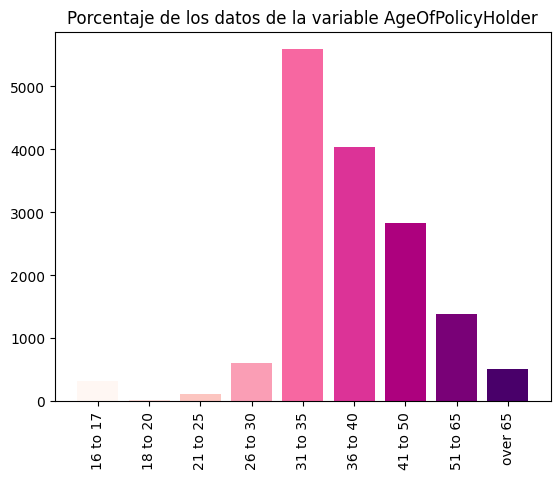

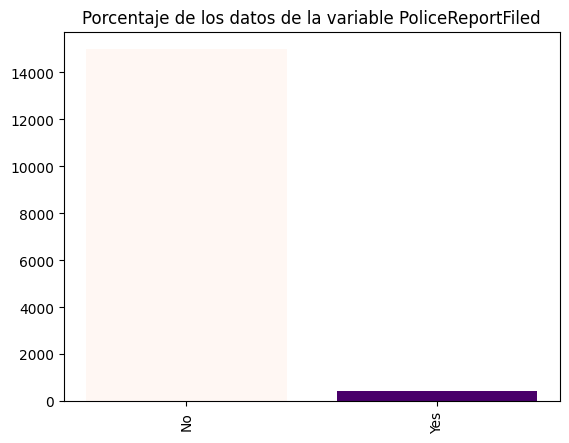

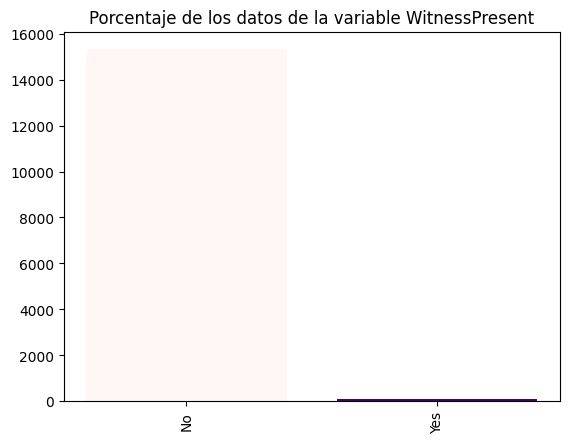

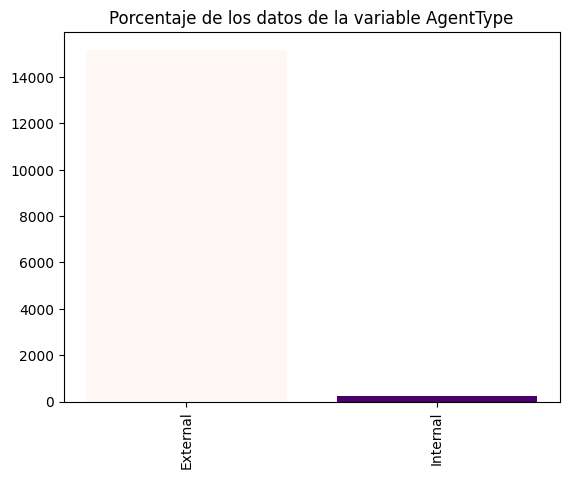

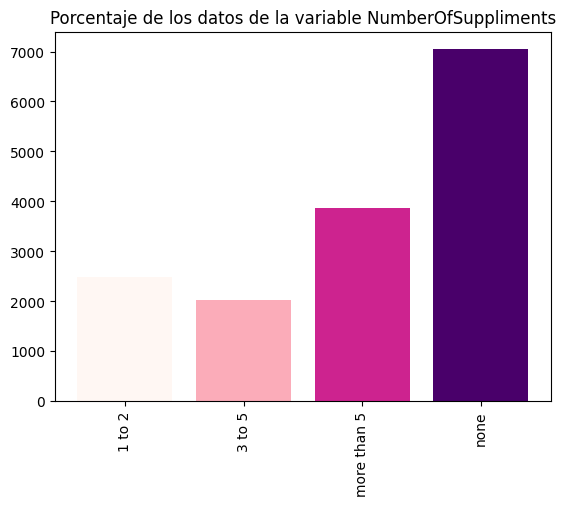

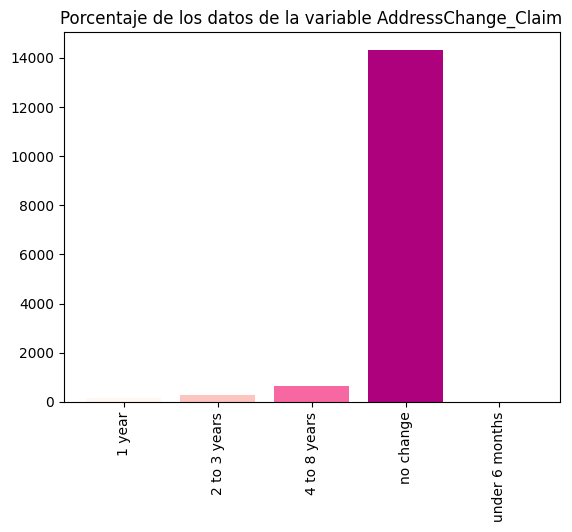

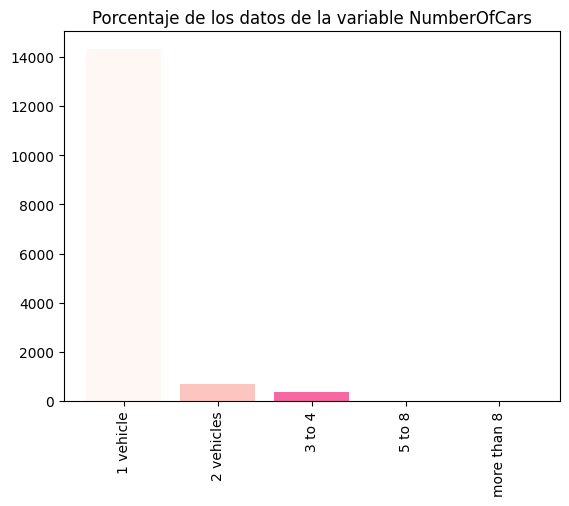

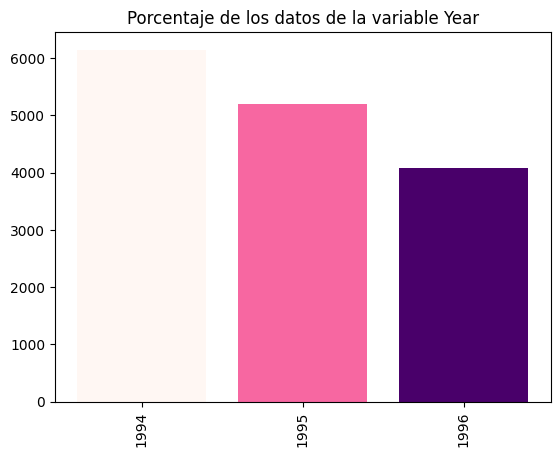

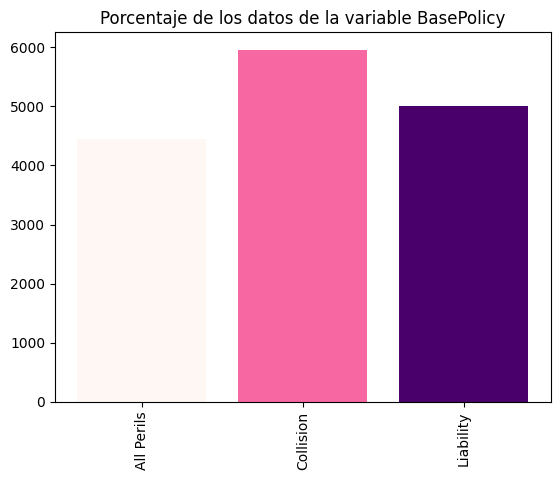

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap


cmap = get_cmap("RdPu")

for i in df_fraude:
    counts = df_fraude[f'{i}'].value_counts().sort_index()
    colors = cmap(np.linspace(0, 1, len(counts)))
    plt.bar(counts.index.astype(str), counts, color=colors)
    plt.title(f'Porcentaje de los datos de la variable {i}')
    plt.xticks(rotation=90)
    plt.show()
    print()


Para conocer la distribución de la variable de respuesta, que es FraudFound_P, se puede generar una gráfica de frecuencia relativas o realizar una gráfica de barras.

In [ ]:
#Se genera un objeto tipo pandas-series
Proporciones_FraudFound_P = df_fraude['FraudFound_P'].value_counts(normalize=True)

#Se crea un marco de datos Pandas a partir del objeto pandas-series
pd.DataFrame(Proporciones_FraudFound_P)

,proportion
FraudFound_P,
0,0.940143
1,0.059857


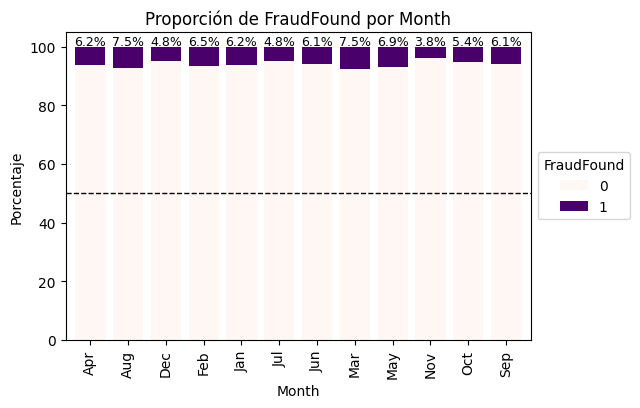

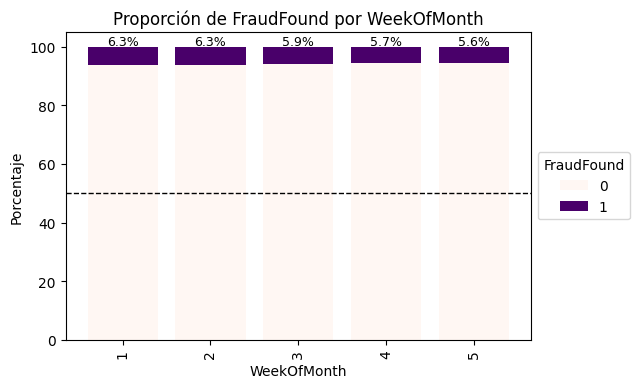

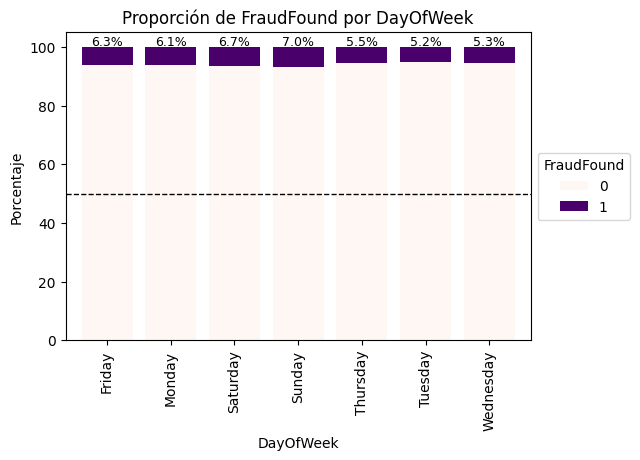

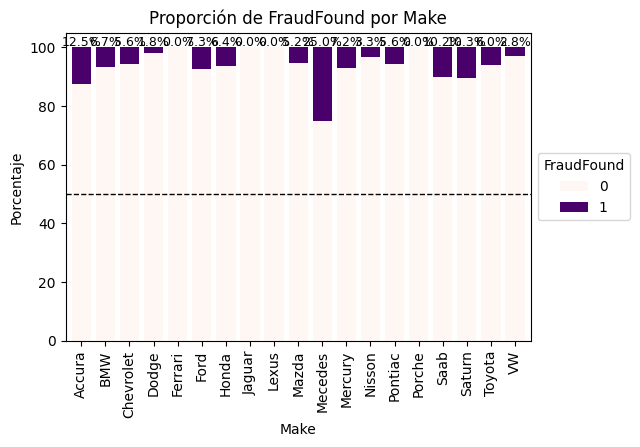

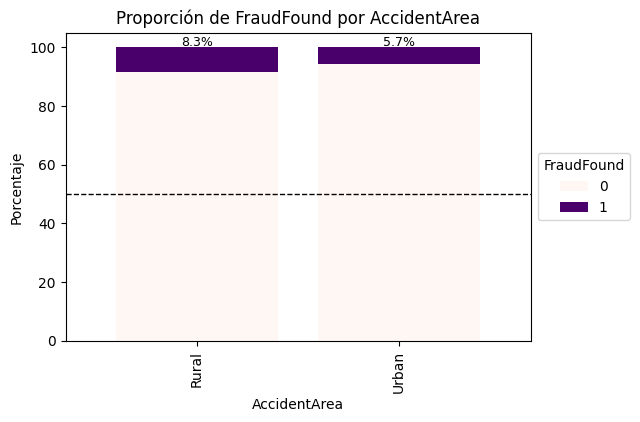

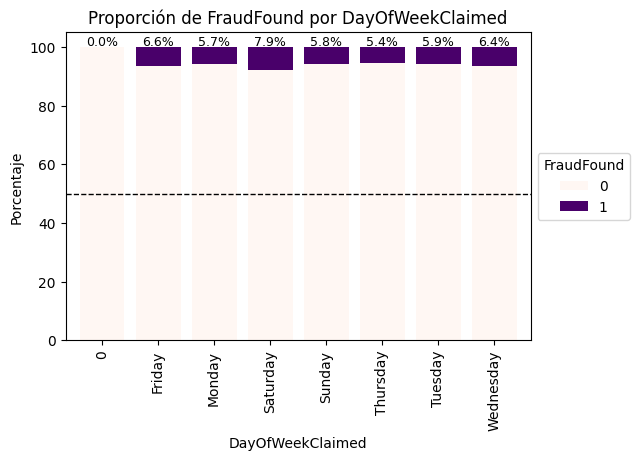

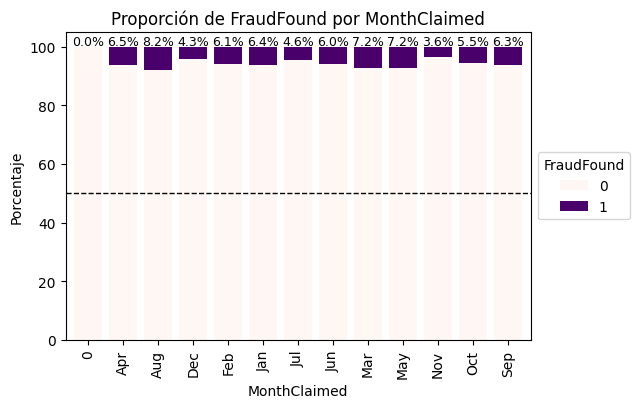

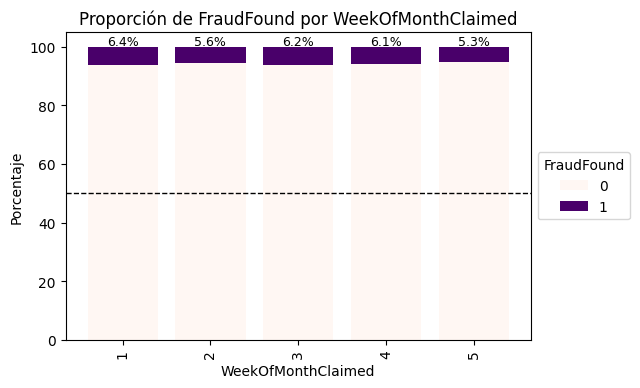

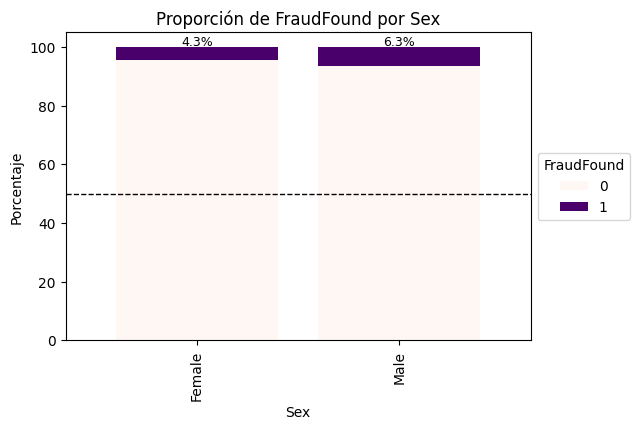

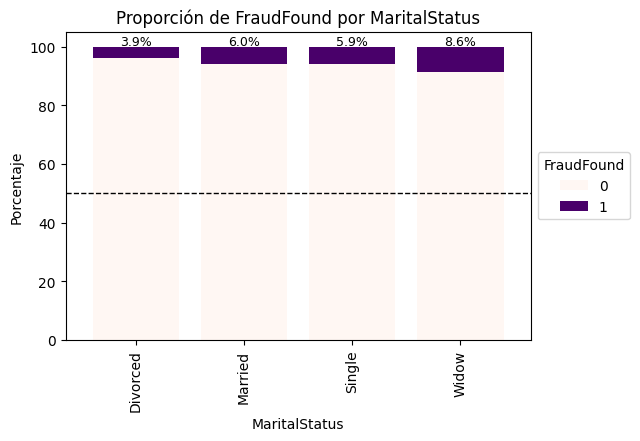

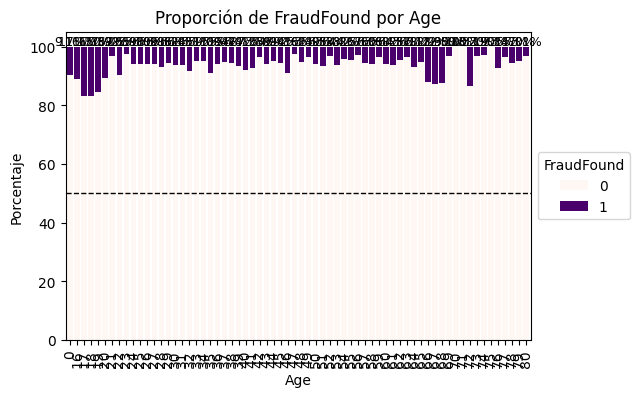

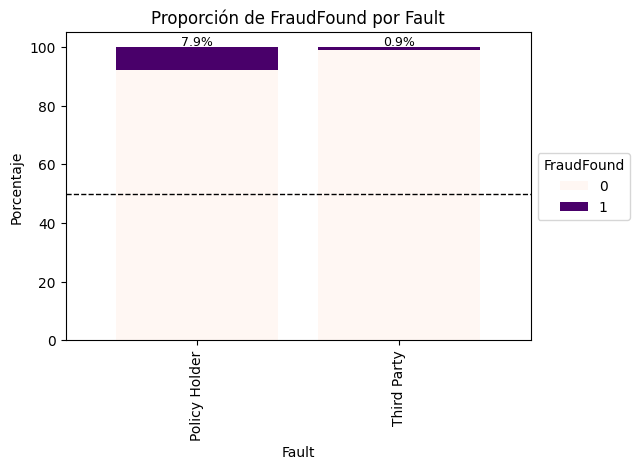

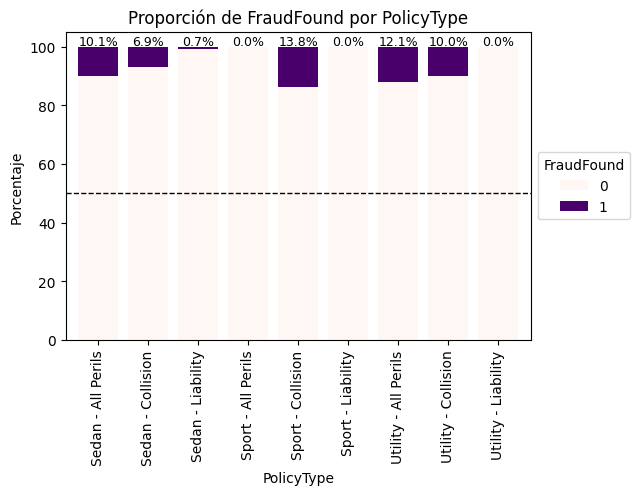

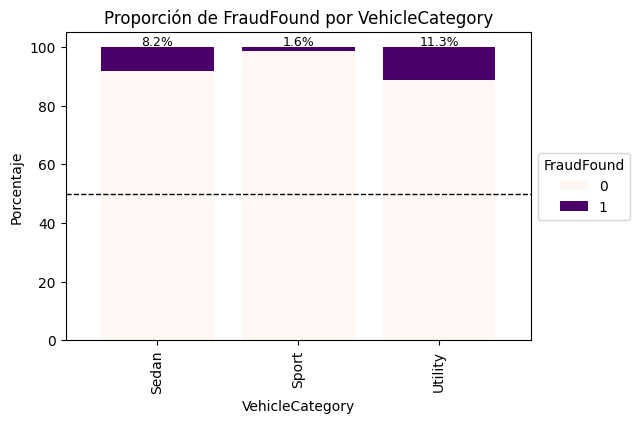

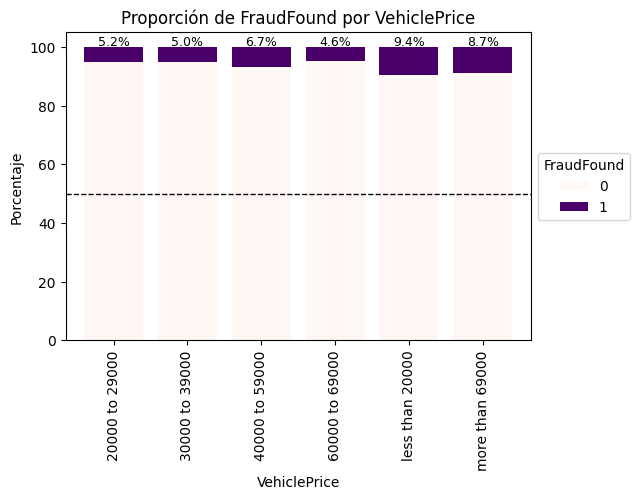

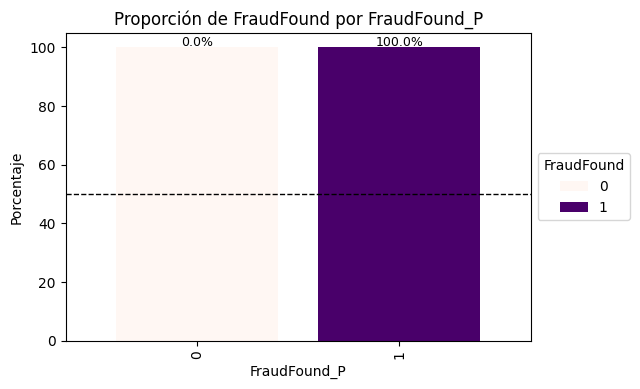

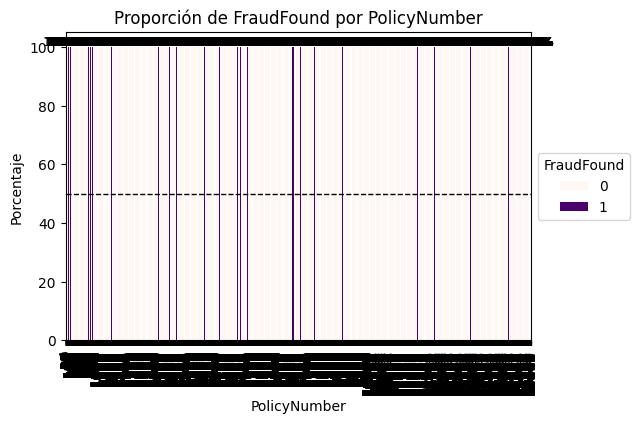

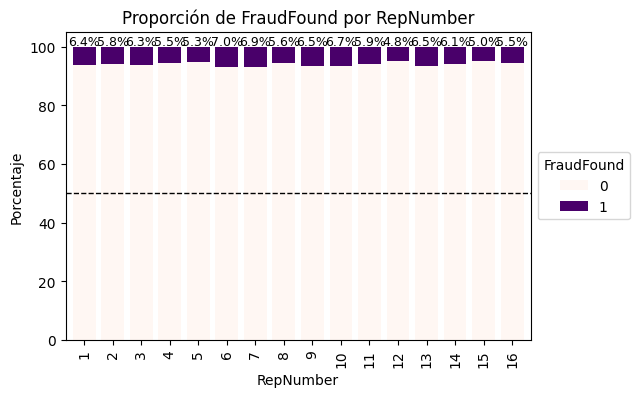

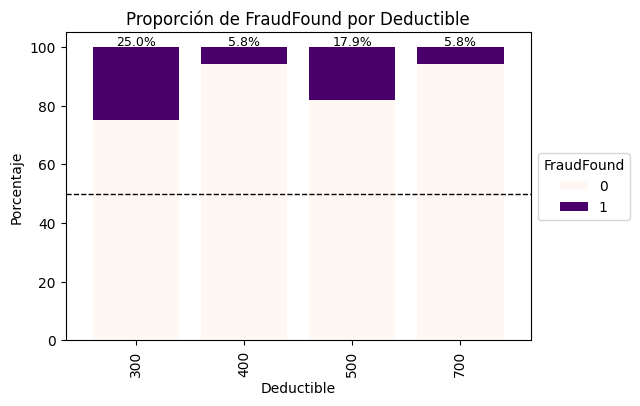

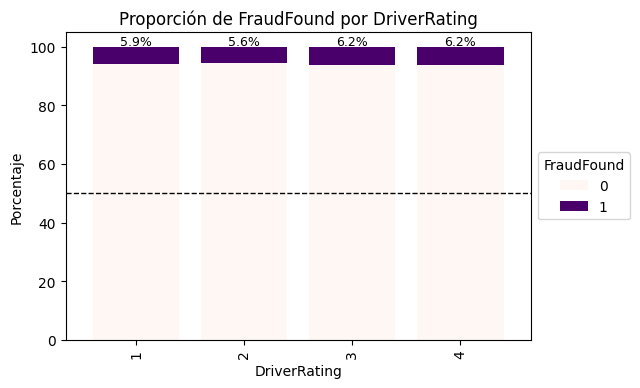

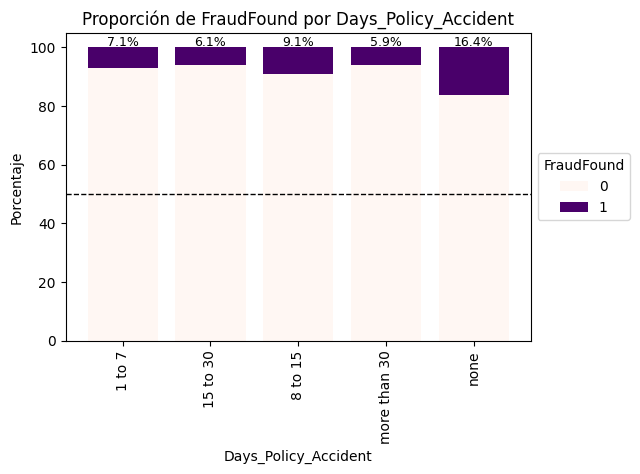

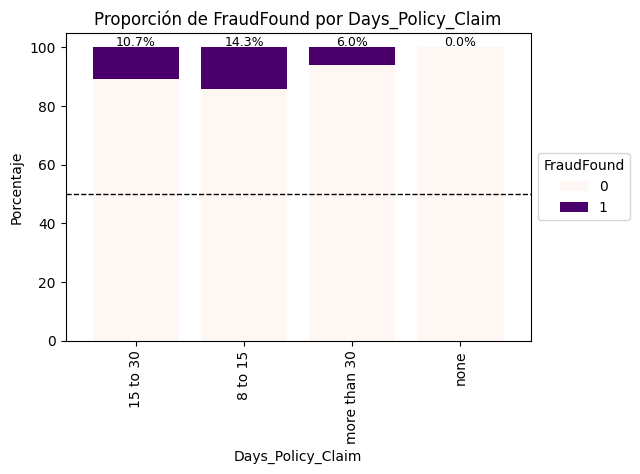

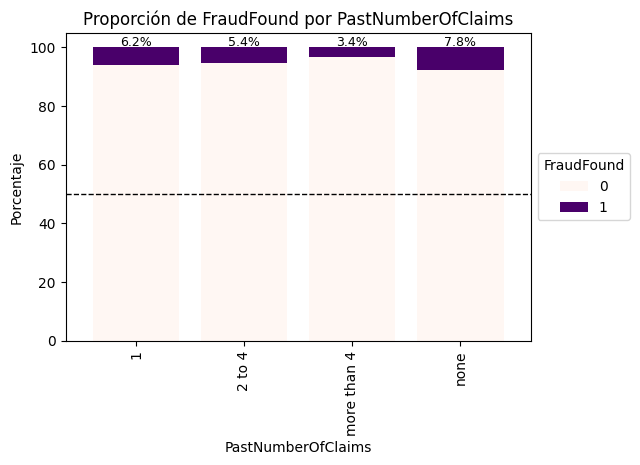

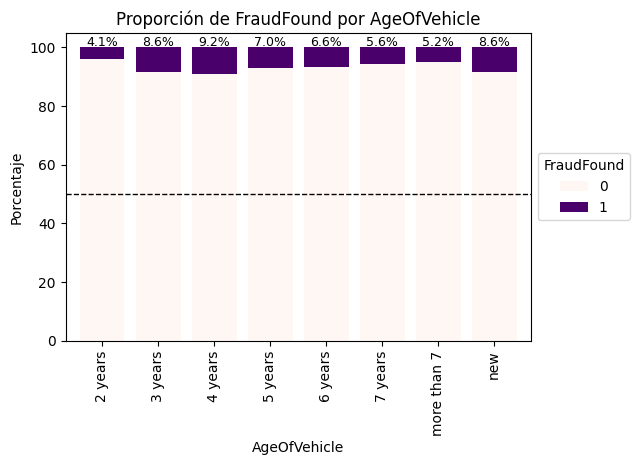

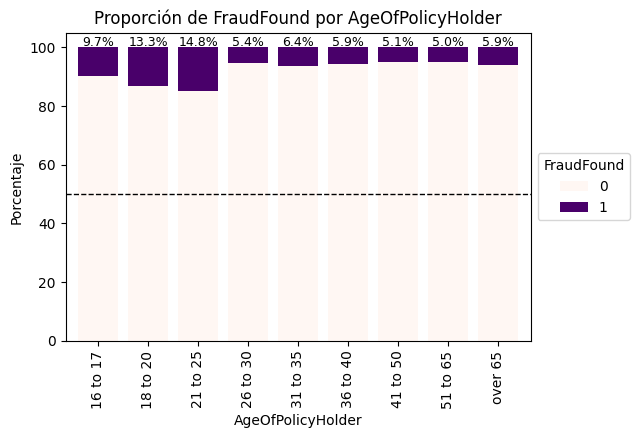

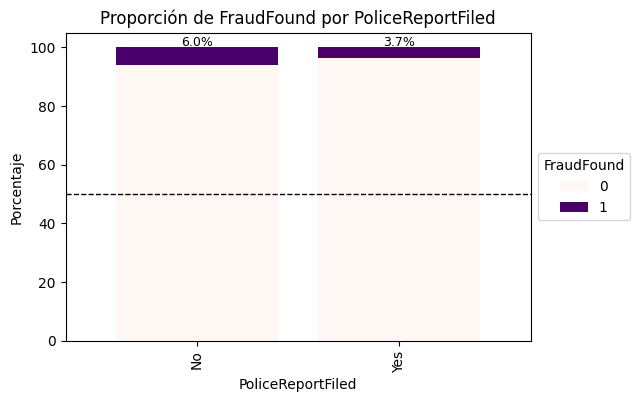

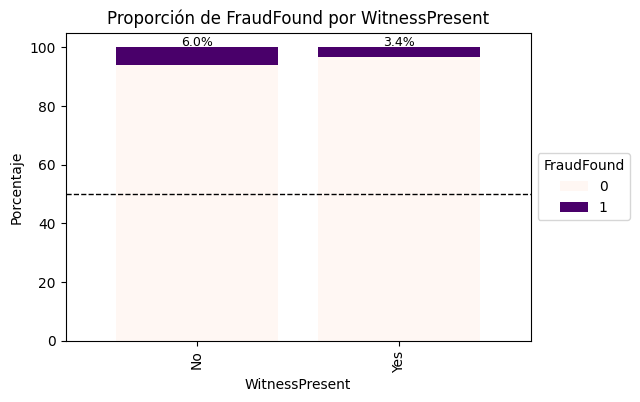

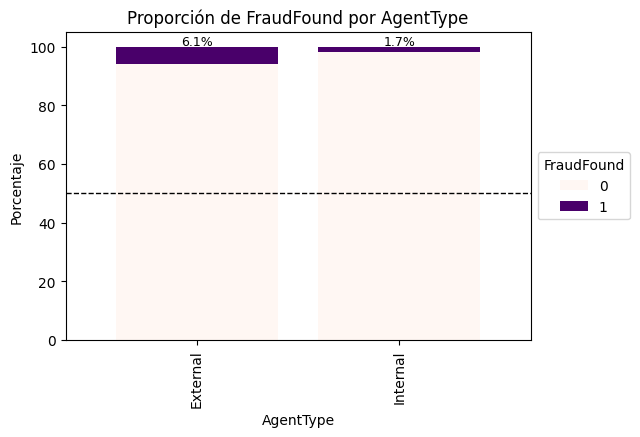

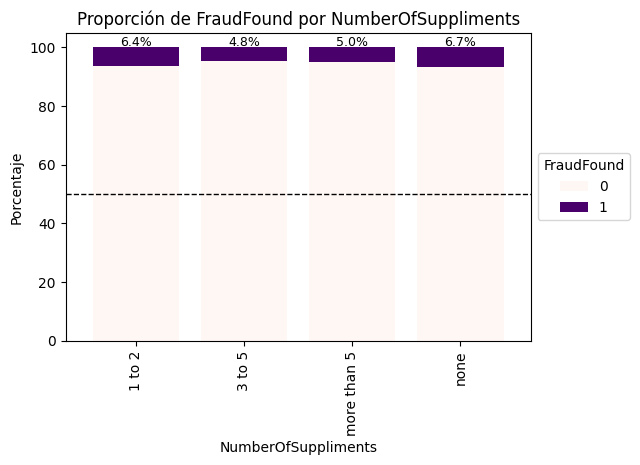

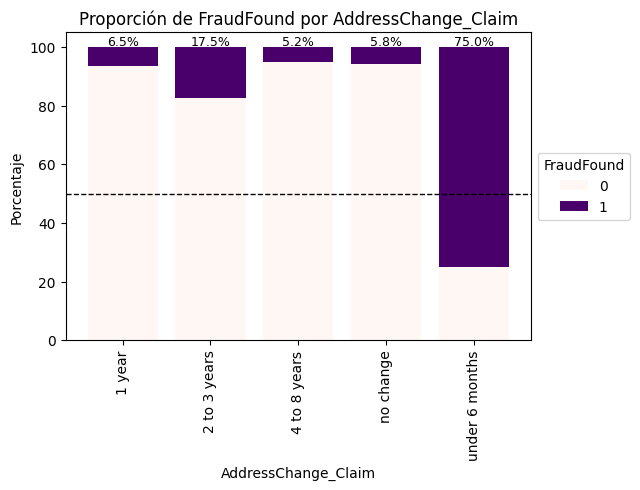

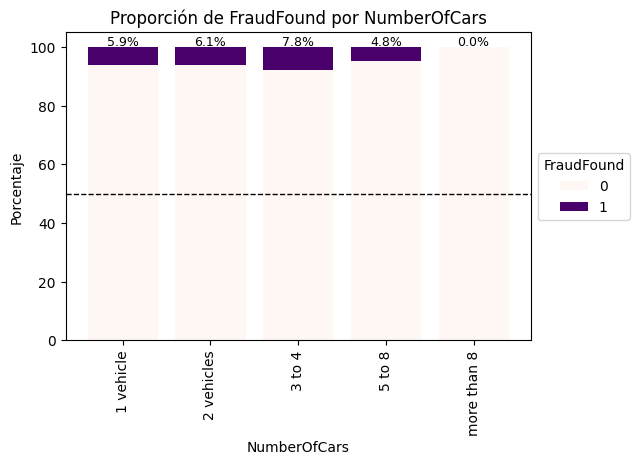

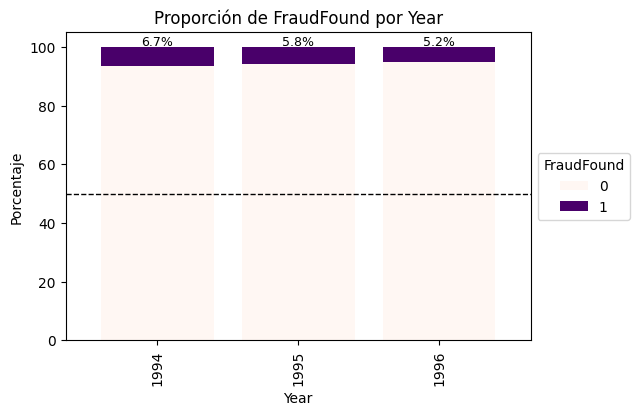

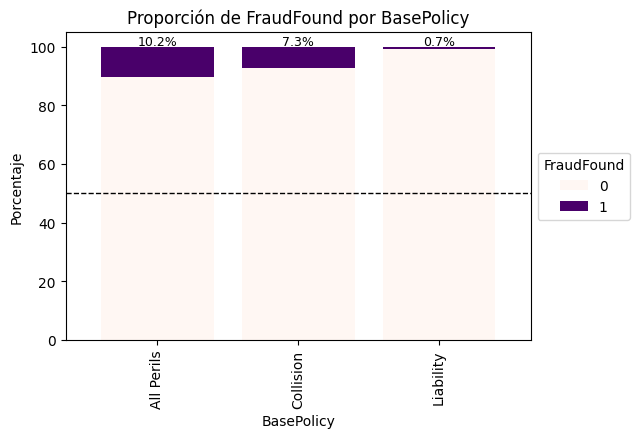

In [ ]:

from matplotlib.colors import ListedColormap

# Definir paleta RdPu en tonos rosados
RdPu = ListedColormap(sns.color_palette("RdPu", 256).as_hex())

# Lista de variables
variables = df_fraude.columns

# Iterar sobre las variables y generar gráficos apilados
for var in variables:

    df_FraudFound_vs_var = pd.crosstab(
        df_fraude[var],
        df_fraude["FraudFound_P"],
        normalize="index"
    ) * 100

    # Ordenar por index de forma automática (útil si es categórica ordenada)
    df_FraudFound_vs_var = df_FraudFound_vs_var.sort_index()

    counts = df_FraudFound_vs_var.index

    colors = RdPu(np.linspace(0, 1, len(df_FraudFound_vs_var.columns)))

    ax = df_FraudFound_vs_var.plot(
        kind="bar",
        stacked=True,
        color=colors,
        width=0.8,
        figsize=(6, 4)
    )

    for i, idx in enumerate(df_FraudFound_vs_var.index):
      value = df_FraudFound_vs_var.loc[idx, 1]  # Porcentaje de fraude (la clase 1)
      ax.annotate(f"{value:.1f}%",
                  xy=(i, 97),                     # posición arriba de la barra
                  xytext=(0, 5),                   # desplazamiento hacia arriba
                  textcoords="offset points",
                  ha="center", va="bottom",
                  fontsize=9, color="black")

    plt.xlabel(var)
    plt.ylabel("Porcentaje")
    plt.title(f"Proporción de FraudFound por {var}")
    plt.legend(title="FraudFound",loc="center left",
    bbox_to_anchor=(1, 0.5) )
    ax.axhline(50, color="black", linestyle="--", linewidth=1)
    plt.show()


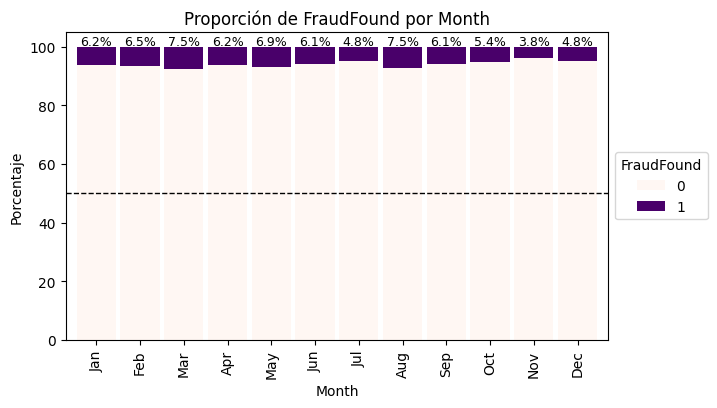

In [ ]:
# Lista de meses en orden correcto
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Convertir Month en categoría ordenada
df_fraude['Month'] = pd.Categorical(df_fraude['Month'],
                                    categories=month_order,
                                    ordered=True)

# Crear el crosstab normalizado
df_FraudFound_vs_var = pd.crosstab(
    df_fraude['Month'],
    df_fraude["FraudFound_P"],
    normalize="index"
) * 100

# Reordena por el índice categórico
df_FraudFound_vs_var = df_FraudFound_vs_var.sort_index()

# Colores
colors = RdPu(np.linspace(0, 1, len(df_FraudFound_vs_var.columns)))

# Plot
ax = df_FraudFound_vs_var.plot(
    kind="bar",
    stacked=True,
    color=colors,
    width=0.9,
    figsize=(7, 4)
)

for i, idx in enumerate(df_FraudFound_vs_var.index):
    value = df_FraudFound_vs_var.loc[idx, 1]  # Porcentaje de fraude (la clase 1)
    ax.annotate(f"{value:.1f}%",
                xy=(i, 97),                     # posición arriba de la barra
                xytext=(0, 5),                   # desplazamiento hacia arriba
                textcoords="offset points",
                ha="center", va="bottom",
                fontsize=9, color="black"
)

plt.xlabel('Month')
plt.ylabel("Porcentaje")
plt.title("Proporción de FraudFound por Month")
plt.legend(title="FraudFound", loc="center left",
    bbox_to_anchor=(1, 0.5)  )
ax.axhline(50, color="black", linestyle="--", linewidth=1)
plt.show()





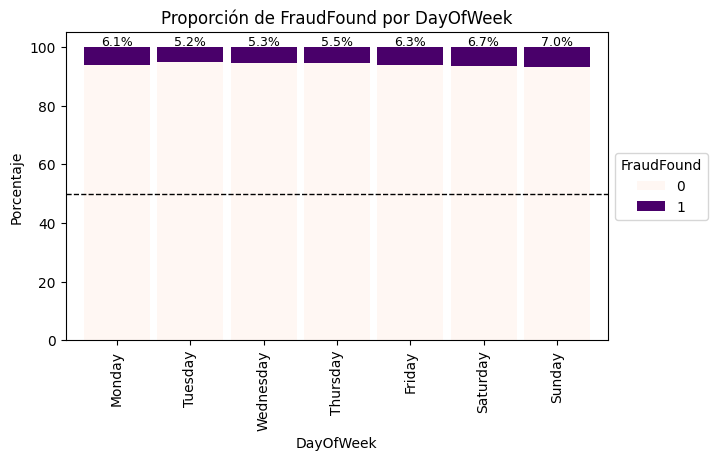

In [ ]:
# DayOfWeek
# Lista de meses en orden correcto
month_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
               'Saturday',"Sunday" ]

# Convertir Month en categoría ordenada
df_fraude['DayOfWeek'] = pd.Categorical(df_fraude['DayOfWeek'],
                                    categories=month_order,
                                    ordered=True)

# Crear el crosstab normalizado
df_FraudFound_vs_var = pd.crosstab(
    df_fraude['DayOfWeek'],
    df_fraude["FraudFound_P"],
    normalize="index"
) * 100

# Reordena por el índice categórico
df_FraudFound_vs_var = df_FraudFound_vs_var.sort_index()

# Colores
colors = RdPu(np.linspace(0, 1, len(df_FraudFound_vs_var.columns)))

# Plot
ax = df_FraudFound_vs_var.plot(
    kind="bar",
    stacked=True,
    color=colors,
    width=0.9,
    figsize=(7, 4)
)
#
for i, idx in enumerate(df_FraudFound_vs_var.index):
    value = df_FraudFound_vs_var.loc[idx, 1]  # Porcentaje de fraude (la clase 1)
    ax.annotate(f"{value:.1f}%",
                xy=(i, 97),                     # posición arriba de la barra
                xytext=(0, 5),                   # desplazamiento hacia arriba
                textcoords="offset points",
                ha="center", va="bottom",
                fontsize=9, color="black"
)

plt.xlabel('DayOfWeek')
plt.ylabel("Porcentaje")
plt.title("Proporción de FraudFound por DayOfWeek")
plt.legend(title="FraudFound", loc="center left",
    bbox_to_anchor=(1, 0.5)  )
ax.axhline(50, color="black", linestyle="--", linewidth=1)
plt.show()





## 5. Ingeniería y transformación de variables.

---


---



In [ ]:
# Filtrar y conservar solo registros 0
datos_cero=df_fraude[df_fraude['MonthClaimed'] == '0'][['MonthClaimed']]

print("Registros filtrados:")
print(datos_cero)

# Eliminar esos registros
df_fraude.drop(datos_cero.index, inplace=True)

Registros filtrados:
     MonthClaimed
1516            0


In [ ]:
# Reemplazar los valores 0 por 16 o 17 aleatoriamente
df_fraude['Age'] = df_fraude['Age'].apply(lambda x: np.random.choice([16, 17]) if x == 0 else x)
print(df_fraude[df_fraude['Age'] == 0][['Age','AgeOfVehicle', 'AgeOfPolicyHolder']])

Empty DataFrame
Columns: [Age, AgeOfVehicle, AgeOfPolicyHolder]
Index: []


In [ ]:
# Verificar y limpiar valores antes de mapear
for col in ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']:
    df_fraude[col] = df_fraude[col].astype(str).str.strip()  # Asegurar que son strings y eliminar espacios
    print(f"Valores únicos en {col}: {df_fraude[col].unique()}")  # Verificar valores únicos



Valores únicos en AccidentArea: ['Urban' 'Rural']
Valores únicos en Sex: ['Female' 'Male']
Valores únicos en Fault: ['Policy Holder' 'Third Party']
Valores únicos en PoliceReportFiled: ['No' 'Yes']
Valores únicos en WitnessPresent: ['No' 'Yes']
Valores únicos en AgentType: ['External' 'Internal']


In [ ]:
# Cambiar variables categoricas binarias a 0 y 1
df_fraude['AccidentArea'] = df_fraude['AccidentArea'].map({'Urban': 0, 'Rural': 1}).astype(int)
df_fraude['Sex'] = df_fraude['Sex'].map({'Male': 0, 'Female': 1}).astype(int)
df_fraude['Fault'] = df_fraude['Fault'].map({'Policy Holder': 0, 'Third Party': 1}).astype(int)

df_fraude['PoliceReportFiled'] = df_fraude['PoliceReportFiled'].map({'No': 0, 'Yes': 1}).astype(int)
df_fraude['WitnessPresent'] = df_fraude['WitnessPresent'].map({'No': 0, 'Yes': 1}).astype(int)
df_fraude['AgentType'] = df_fraude['AgentType'].map({'External': 0, 'Internal': 1}).astype(int)


## 6. Eliminación de algunas variables predictoras

---



In [ ]:
# Quitar variable llave
df_fraude.drop(['PolicyNumber', ], axis = 'columns', inplace = True)

In [ ]:
# Quitar variables categoricas

df_fraude.drop(['Make'], axis = 'columns', inplace = True)
df_fraude.drop(['MaritalStatus'], axis = 'columns', inplace = True)
df_fraude.drop(['PolicyType'], axis = 'columns', inplace = True)
df_fraude.drop(['VehicleCategory'], axis = 'columns', inplace = True)
df_fraude.drop(['VehiclePrice'], axis = 'columns', inplace = True)
df_fraude.drop(['Days_Policy_Accident'], axis = 'columns', inplace = True)
df_fraude.drop(['Days_Policy_Claim'], axis = 'columns', inplace = True)
df_fraude.drop(['PastNumberOfClaims'], axis = 'columns', inplace = True)
df_fraude.drop(['AgeOfVehicle'], axis = 'columns', inplace = True)
df_fraude.drop(['AgeOfPolicyHolder'], axis = 'columns', inplace = True)
df_fraude.drop(['AddressChange_Claim'], axis = 'columns', inplace = True)
df_fraude.drop(['NumberOfSuppliments'], axis = 'columns', inplace = True)
df_fraude.drop(['NumberOfCars'], axis = 'columns', inplace = True)
df_fraude.drop(['BasePolicy'], axis = 'columns', inplace = True)


In [ ]:
#Se carga la clase
from feature_engine.selection import DropConstantFeatures

#Se inicializa el objeto
#Se usa una tolerancia de 0.98 para eliminar
#las variables que muestren el mismo valor en el 96% de las observaciones.
dcf = DropConstantFeatures(tol=0.96)

#Se hace el ajuste sobre los datos para buscar las variables a eliminar
dcf.fit(df_fraude)

DropConstantFeatures(tol=0.96)

In [ ]:
dcf.features_to_drop_

['Deductible', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']

In [ ]:
# Eliminar las columnas especificadas del DataFrame df_fraude
df_fraude = df_fraude.drop(columns=['Deductible', 'PoliceReportFiled',
                                          'WitnessPresent', 'AgentType'])

In [ ]:
#Transformar los datos
df_fraude= dcf.fit_transform(df_fraude)

In [ ]:
#Se importa la clase find_or_check_numerical_variables para
#que regrese una lista con las variables numéricas
from feature_engine.variable_handling import find_numerical_variables

#Se crea una lista de variables numéricas
var_num = find_numerical_variables(df_fraude)
print(var_num)


['WeekOfMonth', 'AccidentArea', 'WeekOfMonthClaimed', 'Sex', 'Age', 'Fault', 'FraudFound_P', 'RepNumber', 'DriverRating', 'Year']


In [ ]:
# Aplica el método corr() al objeto pandas dataframe para obtener la matriz de correlaciones
corr_matrix = df_fraude[var_num].corr()
corr_matrix

,WeekOfMonth,AccidentArea,WeekOfMonthClaimed,Sex,Age,Fault,FraudFound_P,RepNumber,DriverRating,Year
WeekOfMonth,1.000000,-0.009002,0.275366,-0.005332,-0.007773,0.025432,-0.011872,0.005340,-0.016834,-0.003949
AccidentArea,-0.009002,1.000000,-0.006330,-0.033732,-0.003197,-0.008599,0.033557,-0.007039,0.003407,-0.002079
WeekOfMonthClaimed,0.275366,-0.006330,1.000000,-0.003777,0.001415,-0.006391,-0.005783,0.009033,-0.000086,0.012082
Sex,-0.005332,-0.033732,-0.003777,1.000000,-0.089630,-0.000247,-0.029961,0.000873,0.002776,-0.000444
Age,-0.007773,-0.003197,0.001415,-0.089630,1.000000,0.001361,-0.027639,-0.006415,0.001251,0.022315
Fault,0.025432,-0.008599,-0.006391,-0.000247,0.001361,1.000000,-0.131401,-0.006185,-0.010295,0.011116
FraudFound_P,-0.011872,0.033557,-0.005783,-0.029961,-0.027639,-0.131401,1.000000,-0.007529,0.007259,-0.024778
RepNumber,0.005340,-0.007039,0.009033,0.000873,-0.006415,-0.006185,-0.007529,1.000000,0.011072,0.009438
DriverRating,-0.016834,0.003407,-0.000086,0.002776,0.001251,-0.010295,0.007259,0.011072,1.000000,-0.013922
Year,-0.003949,-0.002079,0.012082,-0.000444,0.022315,0.011116,-0.024778,0.009438,-0.013922,1.000000


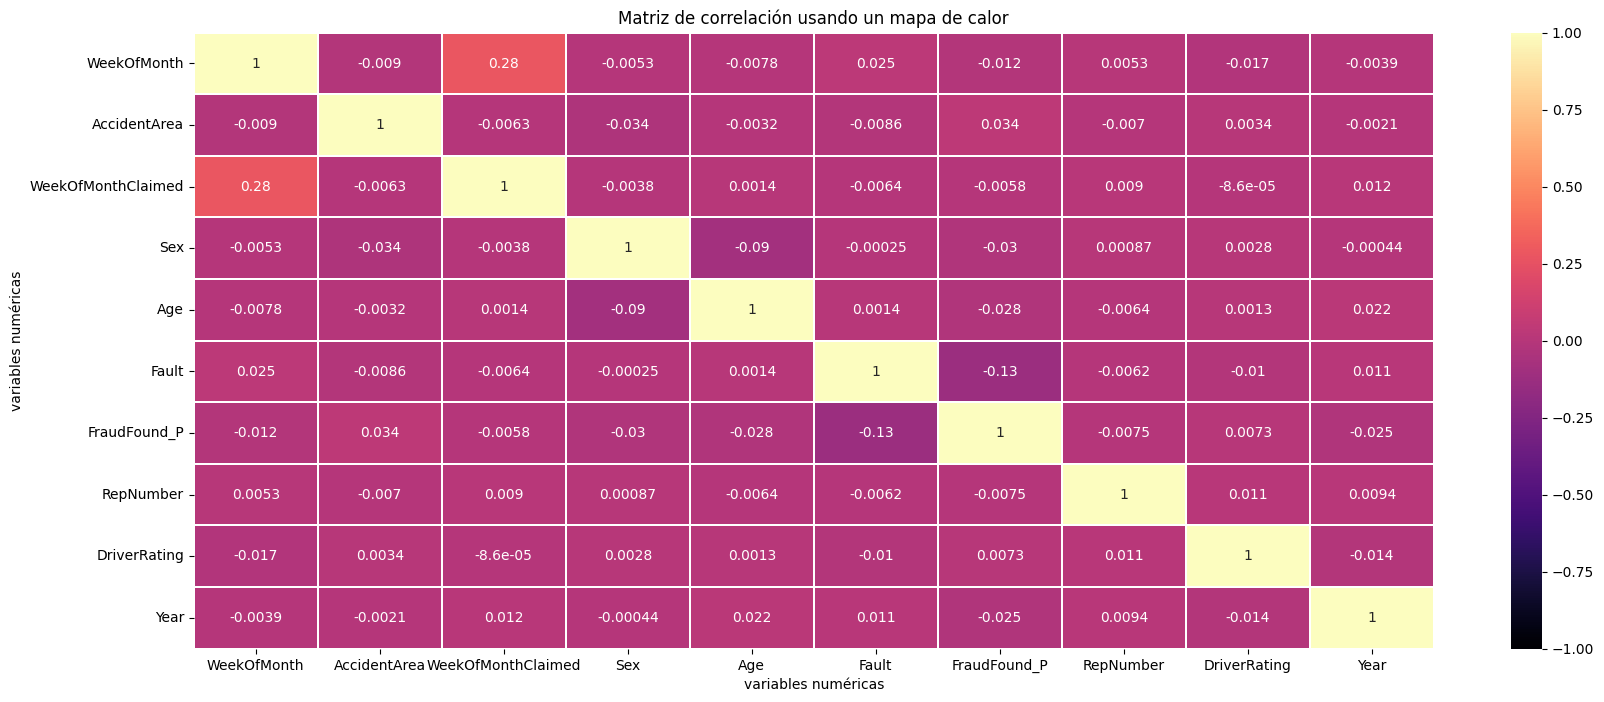

In [ ]:
import seaborn as sns

# Gráfica de calor de la matriz de correlaciones
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='magma' ,
            linewidths=0.1, vmin=-1, vmax=1)
plt.xlabel('variables numéricas')
plt.ylabel('variables numéricas')
plt.title('Matriz de correlación usando un mapa de calor')
plt.show()

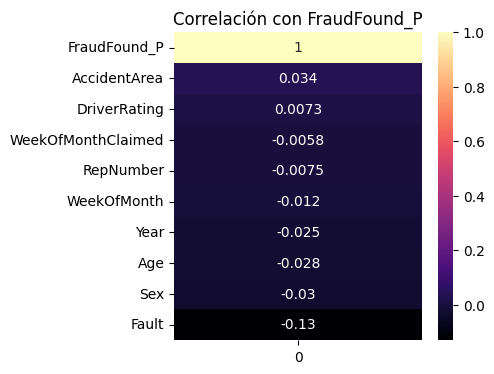

In [ ]:
# Crea una matriz de correlación con la respuesta
target = df_fraude['FraudFound_P']
corr_with_target = df_fraude[var_num].corrwith(target)

# Ordenar de forma descendente
corr_with_target = corr_with_target.sort_values(ascending=False)

# Mapa de calor
plt.figure(figsize=(4, 4))
sns.heatmap(corr_with_target.to_frame(), cmap='magma', annot=True)
plt.title('Correlación con FraudFound_P')
plt.show()

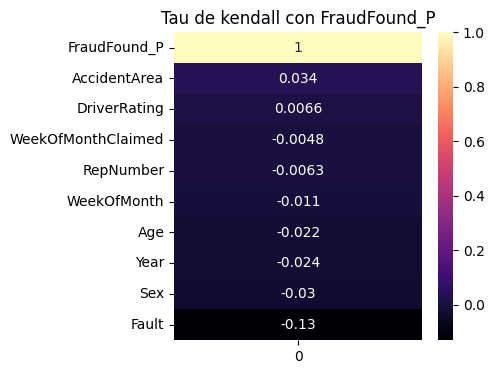

In [ ]:
# Matriz de correlación con la respuesta usando al Tau de Kendall
target = df_fraude['FraudFound_P']
corr_with_target_k = df_fraude[var_num].corrwith(target,method='kendall')

# Ordenar de forma descendente
corr_with_target_k  = corr_with_target_k.sort_values(ascending=False)

# Mapa de calor
plt.figure(figsize=(4, 4))
sns.heatmap(corr_with_target_k.to_frame(), cmap='magma', annot=True)
plt.title('Tau de kendall con FraudFound_P')
plt.show()

Como 'Month' y 'MonthClaimed' están muy correlacionadas, 0.83, hay que quitar una de ellas, podemos ver que 'Month' tiene mayor asociación de kendall tau con la respuesta por lo tanto se elimina 'MonthClaimed'

In [ ]:
df_fraude.drop(['MonthClaimed'], axis = 'columns', inplace = True)

## 7. Análisis de datos atípicos.

---



Vamos a emplear el método feature-engine para identificar las variables que podrían ser eliminadas. Si el análisis sugiere que algunas variables pueden ser descartadas, el código nos proporcionará una lista de las mismas. En caso contrario, no será necesario eliminar ninguna variable.

In [ ]:
%%capture
!pip install feature-engine

In [ ]:
col_numericas=list(df_fraude._get_numeric_data().columns)
col_numericas

['WeekOfMonth',
 'AccidentArea',
 'WeekOfMonthClaimed',
 'Sex',
 'Age',
 'Fault',
 'FraudFound_P',
 'RepNumber',
 'DriverRating',
 'Year']

In [ ]:
# #Se importa la clase Winsorizer
from feature_engine.outliers import Winsorizer

# Se inicializa el objeto que va a limitar los valores atípicos
capper = Winsorizer(
    capping_method='iqr',
    tail='right',
    fold=3,
    variables=['WeekOfMonth', 'WeekOfMonthClaimed', 'Age',
               'RepNumber', 'DriverRating']
)

# Se hace el ajuste sobre los datos
capper.fit(df_fraude)


Winsorizer(capping_method='iqr', fold=3,
           variables=['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'RepNumber',
                      'DriverRating'])

In [ ]:
#Imprimir los límites en un diccionario
print(capper.right_tail_caps_)

{'WeekOfMonth': 10.0, 'WeekOfMonthClaimed': 10.0, 'Age': 99.0, 'RepNumber': 33.0, 'DriverRating': 9.0}


In [ ]:
#Transformar los datos
df_fraude = capper.transform(df_fraude)

## 8. Generación de conjuntos de entrenamiento y validación

---



In [ ]:
df_fraude.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15419 entries, 0 to 15419
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Month               15419 non-null  category
 1   WeekOfMonth         15419 non-null  int64   
 2   DayOfWeek           15419 non-null  category
 3   AccidentArea        15419 non-null  int64   
 4   DayOfWeekClaimed    15419 non-null  object  
 5   WeekOfMonthClaimed  15419 non-null  int64   
 6   Sex                 15419 non-null  int64   
 7   Age                 15419 non-null  int64   
 8   Fault               15419 non-null  int64   
 9   FraudFound_P        15419 non-null  int64   
 10  RepNumber           15419 non-null  int64   
 11  DriverRating        15419 non-null  int64   
 12  Year                15419 non-null  int64   
dtypes: category(2), int64(10), object(1)
memory usage: 1.4+ MB


In [ ]:
df_fraude

,Month,WeekOfMonth,DayOfWeek,AccidentArea,DayOfWeekClaimed,WeekOfMonthClaimed,Sex,Age,Fault,FraudFound_P,RepNumber,DriverRating,Year
0,Dec,5,Wednesday,0,Tuesday,1,1,21,0,0,12,1,1994
1,Jan,3,Wednesday,0,Monday,4,0,34,0,0,15,4,1994
2,Oct,5,Friday,0,Thursday,2,0,47,0,0,7,3,1994
3,Jun,2,Saturday,1,Friday,1,0,65,1,0,4,2,1994
4,Jan,5,Monday,0,Tuesday,2,1,27,1,0,3,1,1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,Friday,0,Tuesday,5,0,35,0,1,5,4,1996
15416,Nov,5,Thursday,0,Friday,1,0,30,0,0,11,3,1996
15417,Nov,5,Thursday,1,Friday,1,0,24,0,1,4,4,1996
15418,Dec,1,Monday,0,Thursday,2,1,34,1,0,6,4,1996


In [ ]:
# Seleccionar columnas de tipo 'object'
df_columnas_object = df_fraude.select_dtypes(include='object').columns.tolist()
df_columnas_object

['DayOfWeekClaimed']

In [ ]:
df_fraude = df_fraude.rename(columns={'FraudFound_P': 'Class'})


In [ ]:
X = df_fraude.drop('Class', axis=1)
y = df_fraude['Class']


In [ ]:
print(len(X.columns))
X.columns.tolist()

12


['Month',
 'WeekOfMonth',
 'DayOfWeek',
 'AccidentArea',
 'DayOfWeekClaimed',
 'WeekOfMonthClaimed',
 'Sex',
 'Age',
 'Fault',
 'RepNumber',
 'DriverRating',
 'Year']

In [ ]:
y

,Class
0,0
1,0
2,0
3,0
4,0
...,...
15415,1
15416,0
15417,1
15418,0


In [ ]:
df_fraude['Class'].value_counts()

,count
Class,
0,14496
1,923


In [ ]:

# Define categorical columns that need to be encoded
categorical_cols_to_encode = ['Month', 'DayOfWeek', 'DayOfWeekClaimed']

# Initialize MeanEncoder
mean_encoder = MeanEncoder(variables=categorical_cols_to_encode)

# Temporarily separate features and target for MeanEncoder fit
X_for_encoding = df_fraude.drop('Class', axis=1)
y_for_encoding = df_fraude['Class']

# Fit the encoder on the features and target
mean_encoder.fit(X_for_encoding, y_for_encoding)

# Transform the categorical columns in dta1
df_fraude[categorical_cols_to_encode] = mean_encoder.transform(X_for_encoding)[categorical_cols_to_encode]


# **Aplicar funciones y obtener resultados**

## Aplicar validación cruzada con tres variantes de smote en los tres modelos

---



---

**Regresión logística**

---



***Stable Smote***

In [ ]:
dta1 = df_fraude.copy()
print("\nDistribución de clases:")
print(dta1['Class'].value_counts())



Distribución de clases:
Class
0    14496
1      923
Name: count, dtype: int64


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
    dta1,
    smote_type="sstable",
    modelo_type="logit"
)

guardar_resultados_smote(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-analisis:Resultados.csv",
  modelo="Regresión logística",
  smote="Stable Smote",
  exactitud_sin_balance=scores_unbalanced,
  mcc_sin_balance=mcc_scores_unbalanced,
  exactitud_SMOTE_50=scores_50,
  mcc_SMOTE_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_SMOTE_opt=scores,
  mcc_SMOTE_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Número de instancias minoritarias necesarias: 12215
Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13046}
Matriz de confusión (Umbral óptimo):
[[1154  296]
 [  56   36]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.4896
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.1206
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.7717
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.1079
MCC-F1 score (Fold 1): 0.3017
Umbral óptimo: 0.7747 — MCC(Normalizado): 0.5539, F1: 0.1698

=== Fold 2 ===
Número de instancias minoritarias necesarias: 12215
Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13046}
Matriz de confusión (Umbral óptimo):
[[643 807]
 [ 13  79]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9403
MCC (da

***Smote TL***

In [ ]:
dta2 = df_fraude.copy()
print("\nDistribución de clases:")
print(dta2['Class'].value_counts())



Distribución de clases:
Class
0    14496
1      923
Name: count, dtype: int64


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
    dta2,
    smote_type="smotetl",
    modelo_type="logit"
)

guardar_resultados_smote(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-analisis:Resultados.csv",
  modelo="Regresión logística",
  smote="Smote TL",
  exactitud_sin_balance=scores_unbalanced,
  mcc_sin_balance=mcc_scores_unbalanced,
  exactitud_SMOTE_50=scores_50,
  mcc_SMOTE_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_SMOTE_opt=scores,
  mcc_SMOTE_opt=mcc_scores,
  confusion_elements=confusion_elements
)

2026-01-31 03:06:35,478:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:06:35,482:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari


=== Fold 1 ===


2026-01-31 03:06:35,577:INFO:TomekLinkRemoval: Running noise removal.
INFO:smote_variants:TomekLinkRemoval: Running noise removal.
2026-01-31 03:06:35,581:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2026-01-31 03:06:35,670:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12979, 1: 12979}


2026-01-31 03:06:42,278:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:06:42,281:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[1283  167]
 [  66   26]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.3891
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.1137
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8489
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.1199
MCC-F1 score (Fold 1): 0.3005
Umbral óptimo: 0.6944 — MCC(Normalizado): 0.5599, F1: 0.1825

=== Fold 2 ===
Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12976, 1: 12976}


2026-01-31 03:06:49,438:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:06:49,443:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[1122  328]
 [  51   41]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.3820
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.1366
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.7542
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.1218
MCC-F1 score (Fold 2): 0.3016
Umbral óptimo: 0.6587 — MCC(Normalizado): 0.5609, F1: 0.1779

=== Fold 3 ===


2026-01-31 03:06:49,639:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12978, 1: 12978}


2026-01-31 03:06:56,500:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:06:56,504:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[1420   30]
 [  77   15]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.4060
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.1367
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9306
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.2003
MCC-F1 score (Fold 3): 0.3089
Umbral óptimo: 0.7533 — MCC(Normalizado): 0.6002, F1: 0.2190

=== Fold 4 ===
Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12958, 1: 12958}


2026-01-31 03:07:03,654:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:07:03,656:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[913 537]
 [ 32  60]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.4053
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.1261
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.6310
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.1370
MCC-F1 score (Fold 4): 0.3005
Umbral óptimo: 0.6101 — MCC(Normalizado): 0.5685, F1: 0.1742

=== Fold 5 ===


2026-01-31 03:07:03,839:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12981, 1: 12981}


2026-01-31 03:07:10,442:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:07:10,445:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[1333  117]
 [  70   22]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.3748
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.1335
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8787
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.1310
MCC-F1 score (Fold 5): 0.2996
Umbral óptimo: 0.7136 — MCC(Normalizado): 0.5655, F1: 0.1905

=== Fold 6 ===
Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12971, 1: 12971}


2026-01-31 03:07:17,562:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:07:17,565:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[1327  123]
 [  67   25]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.4092
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.1587
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.8768
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.1503
MCC-F1 score (Fold 6): 0.3012
Umbral óptimo: 0.7070 — MCC(Normalizado): 0.5751, F1: 0.2083

=== Fold 7 ===


2026-01-31 03:07:17,754:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 12979, 1: 12979}


2026-01-31 03:07:24,466:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:07:24,470:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[1281  168]
 [  69   24]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.4001
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.1300
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.8463
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.1025
MCC-F1 score (Fold 7): 0.3053
Umbral óptimo: 0.6934 — MCC(Normalizado): 0.5512, F1: 0.1684

=== Fold 8 ===
Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 12964, 1: 12964}


2026-01-31 03:07:31,624:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:07:31,626:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[973 476]
 [ 37  56]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.4163
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.1729
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.6673
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.1370
MCC-F1 score (Fold 8): 0.3073
Umbral óptimo: 0.6292 — MCC(Normalizado): 0.5685, F1: 0.1792

=== Fold 9 ===


2026-01-31 03:07:31,793:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 12976, 1: 12976}


2026-01-31 03:07:38,561:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:07:38,564:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[662 787]
 [ 16  77]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.4371
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.1366
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.4792
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.1366
MCC-F1 score (Fold 9): 0.3017
Umbral óptimo: 0.5357 — MCC(Normalizado): 0.5683, F1: 0.1609

=== Fold 10 ===
Distribución antes de SMOTE: {0: 13047, 1: 831}
Distribución después de SMOTE: {0: 12964, 1: 12964}
Matriz de confusión (Umbral óptimo):
[[542 907]
 [ 12  80]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.4173
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.1113
Exactitud (SMOTE con umbral óptimo) Fold 10

***Stable IPF***

In [ ]:
dta3 = df_fraude.copy()
print("\nDistribución de clases:")
print(dta3['Class'].value_counts())



Distribución de clases:
Class
0    14496
1      923
Name: count, dtype: int64


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
    dta3,
    smote_type="smoteipf",
    modelo_type="logit"
)

guardar_resultados_smote(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-analisis:Resultados.csv",
  modelo="Regresión logística",
  smote="Smote IPF",
  exactitud_sin_balance=scores_unbalanced,
  mcc_sin_balance=mcc_scores_unbalanced,
  exactitud_SMOTE_50=scores_50,
  mcc_SMOTE_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_SMOTE_opt=scores,
  mcc_SMOTE_opt=mcc_scores,
  confusion_elements=confusion_elements
)

2026-01-31 03:07:45,975:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:07:45,979:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p


=== Fold 1 ===


2026-01-31 03:07:48,125:INFO:SMOTE_IPF: Removing 2 elements
INFO:smote_variants:SMOTE_IPF: Removing 2 elements
2026-01-31 03:07:49,879:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2026-01-31 03:07:51,664:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13044}


2026-01-31 03:07:57,403:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:07:57,408:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[1282  168]
 [  66   26]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.3885
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.1134
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8482
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.1191
MCC-F1 score (Fold 1): 0.3005
Umbral óptimo: 0.6935 — MCC(Normalizado): 0.5595, F1: 0.1818

=== Fold 2 ===


2026-01-31 03:07:59,659:INFO:SMOTE_IPF: Removing 2 elements
INFO:smote_variants:SMOTE_IPF: Removing 2 elements
2026-01-31 03:08:01,690:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2026-01-31 03:08:03,254:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13044}


2026-01-31 03:08:08,919:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:08:08,921:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[1144  306]
 [  53   39]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.3839
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.1375
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.7672
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.1210
MCC-F1 score (Fold 2): 0.3007
Umbral óptimo: 0.6633 — MCC(Normalizado): 0.5605, F1: 0.1785

=== Fold 3 ===


2026-01-31 03:08:10,651:INFO:SMOTE_IPF: Removing 1 elements
INFO:smote_variants:SMOTE_IPF: Removing 1 elements
2026-01-31 03:08:12,509:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2026-01-31 03:08:14,603:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13045}


2026-01-31 03:08:20,525:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:08:20,527:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[1420   30]
 [  77   15]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.4073
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.1373
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9306
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.2003
MCC-F1 score (Fold 3): 0.3090
Umbral óptimo: 0.7529 — MCC(Normalizado): 0.6002, F1: 0.2190

=== Fold 4 ===


2026-01-31 03:08:22,136:INFO:SMOTE_IPF: Removing 1 elements
INFO:smote_variants:SMOTE_IPF: Removing 1 elements
2026-01-31 03:08:23,698:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2026-01-31 03:08:25,243:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13045}


2026-01-31 03:08:32,302:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:08:32,305:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[913 537]
 [ 32  60]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.4053
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.1261
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.6310
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.1370
MCC-F1 score (Fold 4): 0.3008
Umbral óptimo: 0.6088 — MCC(Normalizado): 0.5685, F1: 0.1742

=== Fold 5 ===


2026-01-31 03:08:34,108:INFO:SMOTE_IPF: Removing 2 elements
INFO:smote_variants:SMOTE_IPF: Removing 2 elements
2026-01-31 03:08:35,866:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2026-01-31 03:08:37,607:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13044}


2026-01-31 03:08:44,513:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:08:44,515:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[1351   99]
 [  72   20]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.3748
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.1335
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8891
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.1324
MCC-F1 score (Fold 5): 0.2988
Umbral óptimo: 0.7206 — MCC(Normalizado): 0.5662, F1: 0.1896

=== Fold 6 ===


2026-01-31 03:08:46,169:INFO:SMOTE_IPF: Removing 2 elements
INFO:smote_variants:SMOTE_IPF: Removing 2 elements
2026-01-31 03:08:47,774:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2026-01-31 03:08:49,362:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13044}


2026-01-31 03:08:55,868:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:08:55,873:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[1326  124]
 [  67   25]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.4086
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.1533
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.8761
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.1493
MCC-F1 score (Fold 6): 0.3017
Umbral óptimo: 0.7065 — MCC(Normalizado): 0.5746, F1: 0.2075

=== Fold 7 ===


2026-01-31 03:08:57,919:INFO:SMOTE_IPF: Removing 1 elements
INFO:smote_variants:SMOTE_IPF: Removing 1 elements
2026-01-31 03:08:59,414:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2026-01-31 03:09:00,954:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 13047, 1: 13046}


2026-01-31 03:09:06,537:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:09:06,539:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[1279  170]
 [  68   25]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.4001
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.1300
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.8457
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.1085
MCC-F1 score (Fold 7): 0.3055
Umbral óptimo: 0.6921 — MCC(Normalizado): 0.5543, F1: 0.1736

=== Fold 8 ===


2026-01-31 03:09:08,469:INFO:SMOTE_IPF: Removing 1 elements
INFO:smote_variants:SMOTE_IPF: Removing 1 elements
2026-01-31 03:09:10,653:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2026-01-31 03:09:12,539:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 13047, 1: 13046}


2026-01-31 03:09:18,039:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:09:18,041:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[988 461]
 [ 38  55]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.4170
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.1732
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.6764
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.1379
MCC-F1 score (Fold 8): 0.3075
Umbral óptimo: 0.6309 — MCC(Normalizado): 0.5689, F1: 0.1806

=== Fold 9 ===


2026-01-31 03:09:19,938:INFO:SMOTE_IPF: Removing 2 elements
INFO:smote_variants:SMOTE_IPF: Removing 2 elements
2026-01-31 03:09:21,878:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2026-01-31 03:09:24,380:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 13047, 1: 13045}


2026-01-31 03:09:30,476:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:09:30,478:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[666 783]
 [ 16  77]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.4377
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.1369
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.4818
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.1378
MCC-F1 score (Fold 9): 0.3014
Umbral óptimo: 0.5368 — MCC(Normalizado): 0.5689, F1: 0.1616

=== Fold 10 ===


2026-01-31 03:09:32,216:INFO:SMOTE_IPF: Removing 2 elements
INFO:smote_variants:SMOTE_IPF: Removing 2 elements
2026-01-31 03:09:33,855:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2026-01-31 03:09:35,503:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 13047, 1: 831}
Distribución después de SMOTE: {0: 13047, 1: 13045}
Matriz de confusión (Umbral óptimo):
[[629 820]
 [ 18  74]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.4173
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.1113
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.4562
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.1145
MCC-F1 score (Fold 10): 0.2935
Umbral óptimo: 0.5307 — MCC(Normalizado): 0.5572, F1: 0.1501

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9401 ± 0.0003
MCC medio (datos de entrenamiento desbalanceados) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral 50%) : 0.4040 ± 0.0174
MCC medio (SMOTE con umbral 50%) : 0.1352 ± 0.0172
Exactitud media (SMOTE con umbral óptimo) : 0.7402 ± 0.1624
MCC medio (SMOTE con umbral óptimo) :

**Gradient Boosting**

---



***Stable Smote***

In [ ]:
dta4 = df_fraude.copy()
print("\nDistribución de clases:")
print(dta4['Class'].value_counts())



Distribución de clases:
Class
0    14496
1      923
Name: count, dtype: int64


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced   = aplicar_validacion_cruzada_smote(
    dta4,
    smote_type="sstable",
    modelo_type="gbm"
)

guardar_resultados_smote(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-analisis:Resultados.csv",
  modelo="Gradient Boosting",
  smote= "Stable Smote",
  exactitud_sin_balance=scores_unbalanced,
  mcc_sin_balance=mcc_scores_unbalanced,
  exactitud_SMOTE_50=scores_50,
  mcc_SMOTE_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_SMOTE_opt=scores,
  mcc_SMOTE_opt=mcc_scores,
  confusion_elements=confusion_elements
)




=== Fold 1 ===
Número de instancias minoritarias necesarias: 12215
Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13046}
Matriz de confusión (Umbral óptimo):
[[944 506]
 [ 44  48]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.0746
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0107
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.6433
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0853
MCC-F1 score (Fold 1): 0.2892
Umbral óptimo: 0.9657 — MCC(Normalizado): 0.5426, F1: 0.1486

=== Fold 2 ===
Número de instancias minoritarias necesarias: 12215
Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13046}
Matriz de confusión (Umbral óptimo):
[[1286  164]
 [  68   24]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9403
MCC (da

***Smote TL***

In [ ]:
dta5 = df_fraude.copy()
print("\nDistribución de clases:")
print(dta5['Class'].value_counts())



Distribución de clases:
Class
0    14496
1      923
Name: count, dtype: int64


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced   = aplicar_validacion_cruzada_smote(
    dta5,
    smote_type="smotetl",
    modelo_type="gbm"
)

guardar_resultados_smote(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-analisis:Resultados.csv",
  modelo="Gradient Boosting",
  smote= "Smote TL",
  exactitud_sin_balance=scores_unbalanced,
  mcc_sin_balance=mcc_scores_unbalanced,
  exactitud_SMOTE_50=scores_50,
  mcc_SMOTE_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_SMOTE_opt=scores,
  mcc_SMOTE_opt=mcc_scores,
  confusion_elements=confusion_elements
)




=== Fold 1 ===


2026-01-31 03:23:47,346:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:23:47,349:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12979, 1: 12979}
Matriz de confusión (Umbral óptimo):
[[  32 1418]
 [   1   91]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.0798
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0183
MCC-F1 score (Fold 1): 0.2611
Umbral óptimo: 0.9712 — MCC(Normalizado): 0.5092, F1: 0.1137

=== Fold 2 ===


2026-01-31 03:24:02,568:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:24:02,572:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12976, 1: 12976}
Matriz de confusión (Umbral óptimo):
[[  14 1436]
 [   0   92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.0687
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0241
MCC-F1 score (Fold 2): 0.2539
Umbral óptimo: 0.9746 — MCC(Normalizado): 0.5121, F1: 0.1136

=== Fold 3 ===


2026-01-31 03:24:18,481:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:24:18,483:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12978, 1: 12978}
Matriz de confusión (Umbral óptimo):
[[ 116 1334]
 [   4   88]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.1323
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0323
MCC-F1 score (Fold 3): 0.2636
Umbral óptimo: 0.9773 — MCC(Normalizado): 0.5161, F1: 0.1162

=== Fold 4 ===


2026-01-31 03:24:33,978:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:24:33,980:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12958, 1: 12958}
Matriz de confusión (Umbral óptimo):
[[ 161 1289]
 [   7   85]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.1595
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0266
MCC-F1 score (Fold 4): 0.2642
Umbral óptimo: 0.9875 — MCC(Normalizado): 0.5133, F1: 0.1160

=== Fold 5 ===


2026-01-31 03:24:49,399:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:24:49,402:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12981, 1: 12981}
Matriz de confusión (Umbral óptimo):
[[   6 1444]
 [   0   92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.0636
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0157
MCC-F1 score (Fold 5): 0.2503
Umbral óptimo: 0.9582 — MCC(Normalizado): 0.5079, F1: 0.1130

=== Fold 6 ===


2026-01-31 03:25:05,121:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:25:05,125:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12971, 1: 12971}
Matriz de confusión (Umbral óptimo):
[[  45 1405]
 [   1   91]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.0882
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0281
MCC-F1 score (Fold 6): 0.2554
Umbral óptimo: 0.9789 — MCC(Normalizado): 0.5140, F1: 0.1146

=== Fold 7 ===


2026-01-31 03:25:21,194:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:25:21,197:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 12979, 1: 12979}
Matriz de confusión (Umbral óptimo):
[[  21 1428]
 [   0   93]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.0603
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.0739
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0298
MCC-F1 score (Fold 7): 0.2513
Umbral óptimo: 0.9789 — MCC(Normalizado): 0.5149, F1: 0.1152

=== Fold 8 ===


2026-01-31 03:25:36,368:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:25:36,372:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 12964, 1: 12964}
Matriz de confusión (Umbral óptimo):
[[  33 1416]
 [   2   91]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.0603
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.0804
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0020
MCC-F1 score (Fold 8): 0.2568
Umbral óptimo: 0.9695 — MCC(Normalizado): 0.5010, F1: 0.1138

=== Fold 9 ===


2026-01-31 03:25:53,137:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:25:53,141:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 12976, 1: 12976}
Matriz de confusión (Umbral óptimo):
[[  47 1402]
 [   1   92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9390
MCC (datos de entrenamiento desbalanceados) en Fold 9: -0.0065
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.0603
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.0901
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0297
MCC-F1 score (Fold 9): 0.2715
Umbral óptimo: 0.9741 — MCC(Normalizado): 0.5149, F1: 0.1159

=== Fold 10 ===


2026-01-31 03:26:09,163:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:26:09,168:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13047, 1: 831}
Distribución después de SMOTE: {0: 12964, 1: 12964}
Matriz de confusión (Umbral óptimo):
[[ 223 1226]
 [  11   81]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9396
MCC (datos de entrenamiento desbalanceados) en Fold 10: -0.0064
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.1973
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0227
MCC-F1 score (Fold 10): 0.2723
Umbral óptimo: 0.9857 — MCC(Normalizado): 0.5113, F1: 0.1158

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9400 ± 0.0004
MCC medio (datos de entrenamiento desbalanceados) : -0.0013 ± 0.0026
Exactitud media (SMOTE con umbral 50%) : 0.0599 ± 0.0003
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.1034 ± 0.0424
MCC medio (SMOTE con umbral ópt

***Stable IPF***

In [ ]:
dta6 = df_fraude.copy()
print("\nDistribución de clases:")
print(dta6['Class'].value_counts())



Distribución de clases:
Class
0    14496
1      923
Name: count, dtype: int64


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
    dta6,
    smote_type="smoteipf",
    modelo_type="gbm"
)

guardar_resultados_smote(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-analisis:Resultados.csv",
  modelo="Gradient Boosting",
  smote= "Smote IPF",
  exactitud_sin_balance=scores_unbalanced,
  mcc_sin_balance=mcc_scores_unbalanced,
  exactitud_SMOTE_50=scores_50,
  mcc_SMOTE_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_SMOTE_opt=scores,
  mcc_SMOTE_opt=mcc_scores,
  confusion_elements=confusion_elements
)




=== Fold 1 ===


2026-01-31 03:26:25,205:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:26:25,209:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13044}
Matriz de confusión (Umbral óptimo):
[[  26 1424]
 [   1   91]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.0759
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0128
MCC-F1 score (Fold 1): 0.2538
Umbral óptimo: 0.9779 — MCC(Normalizado): 0.5064, F1: 0.1133

=== Fold 2 ===


2026-01-31 03:26:45,923:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:26:45,927:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13044}
Matriz de confusión (Umbral óptimo):
[[  15 1435]
 [   0   92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.0694
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0250
MCC-F1 score (Fold 2): 0.2616
Umbral óptimo: 0.9759 — MCC(Normalizado): 0.5125, F1: 0.1137

=== Fold 3 ===


2026-01-31 03:27:23,152:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:27:23,154:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13045}
Matriz de confusión (Umbral óptimo):
[[ 186 1264]
 [   8   84]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.1751
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0295
MCC-F1 score (Fold 3): 0.2666
Umbral óptimo: 0.9801 — MCC(Normalizado): 0.5148, F1: 0.1167

=== Fold 4 ===


2026-01-31 03:27:42,725:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:27:42,730:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13045}
Matriz de confusión (Umbral óptimo):
[[  20 1430]
 [   0   92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.0726
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0289
MCC-F1 score (Fold 4): 0.2531
Umbral óptimo: 0.9784 — MCC(Normalizado): 0.5144, F1: 0.1140

=== Fold 5 ===


2026-01-31 03:28:03,833:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:28:03,836:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13044}
Matriz de confusión (Umbral óptimo):
[[  12 1438]
 [   0   92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.0674
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0223
MCC-F1 score (Fold 5): 0.2587
Umbral óptimo: 0.9637 — MCC(Normalizado): 0.5112, F1: 0.1134

=== Fold 6 ===


2026-01-31 03:28:24,470:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:28:24,473:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13044}
Matriz de confusión (Umbral óptimo):
[[  38 1412]
 [   0   92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.0843
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0400
MCC-F1 score (Fold 6): 0.2498
Umbral óptimo: 0.9805 — MCC(Normalizado): 0.5200, F1: 0.1153

=== Fold 7 ===


2026-01-31 03:28:47,793:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:28:47,798:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 13047, 1: 13046}
Matriz de confusión (Umbral óptimo):
[[ 103 1346]
 [   5   88]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.0603
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.1239
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0162
MCC-F1 score (Fold 7): 0.2534
Umbral óptimo: 0.9791 — MCC(Normalizado): 0.5081, F1: 0.1153

=== Fold 8 ===


2026-01-31 03:29:22,170:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:29:22,174:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 13047, 1: 13046}
Matriz de confusión (Umbral óptimo):
[[ 169 1280]
 [   8   85]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.0603
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.1647
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0229
MCC-F1 score (Fold 8): 0.2619
Umbral óptimo: 0.9858 — MCC(Normalizado): 0.5114, F1: 0.1166

=== Fold 9 ===


2026-01-31 03:29:43,481:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:29:43,484:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 13047, 1: 13045}
Matriz de confusión (Umbral óptimo):
[[1028  421]
 [  58   35]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9390
MCC (datos de entrenamiento desbalanceados) en Fold 9: -0.0065
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.0603
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.6894
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0448
MCC-F1 score (Fold 9): 0.2691
Umbral óptimo: 0.9945 — MCC(Normalizado): 0.5224, F1: 0.1275

=== Fold 10 ===


2026-01-31 03:30:03,932:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:30:03,937:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13047, 1: 831}
Distribución después de SMOTE: {0: 13047, 1: 13045}
Matriz de confusión (Umbral óptimo):
[[956 493]
 [ 57  35]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9396
MCC (datos de entrenamiento desbalanceados) en Fold 10: -0.0064
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.6431
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0201
MCC-F1 score (Fold 10): 0.2643
Umbral óptimo: 0.9935 — MCC(Normalizado): 0.5100, F1: 0.1129

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9400 ± 0.0004
MCC medio (datos de entrenamiento desbalanceados) : -0.0013 ± 0.0026
Exactitud media (SMOTE con umbral 50%) : 0.0599 ± 0.0003
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.2166 ± 0.2281
MCC medio (SMOTE con umbral óptimo)

**Random Forest**

---



***Stable Smote***

In [ ]:
dta7 = df_fraude.copy()
print("\nDistribución de clases:")
print(dta7['Class'].value_counts())



Distribución de clases:
Class
0    14496
1      923
Name: count, dtype: int64


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
    dta7,
    smote_type="sstable",
    modelo_type="rf"
)

guardar_resultados_smote(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-analisis:Resultados.csv",
  modelo="Random Forest",
  smote= "Stable Smote",
  exactitud_sin_balance=scores_unbalanced,
  mcc_sin_balance=mcc_scores_unbalanced,
  exactitud_SMOTE_50=scores_50,
  mcc_SMOTE_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_SMOTE_opt=scores,
  mcc_SMOTE_opt=mcc_scores,
  confusion_elements=confusion_elements
)


=== Fold 1 ===
Número de instancias minoritarias necesarias: 12215
Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13046}
Matriz de confusión (Umbral óptimo):
[[861 589]
 [ 32  60]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.4183
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0866
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.5973
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.1180
MCC-F1 score (Fold 1): 0.3047
Umbral óptimo: 0.7300 — MCC(Normalizado): 0.5590, F1: 0.1619

=== Fold 2 ===
Número de instancias minoritarias necesarias: 12215
Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13046}
Matriz de confusión (Umbral óptimo):
[[899 551]
 [ 34  58]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9410
MCC (datos 

***Smote TL***

In [ ]:
dta8 = df_fraude.copy()
print("\nDistribución de clases:")
print(dta8['Class'].value_counts())



Distribución de clases:
Class
0    14496
1      923
Name: count, dtype: int64


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
        dta8,
        smote_type="smotetl",
        modelo_type="rf"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-analisis:Resultados.csv",
      modelo="Random Forest",
      smote="Smote TL",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===


2026-01-31 03:43:35,333:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:43:35,335:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12979, 1: 12979}
Matriz de confusión (Umbral óptimo):
[[  13 1437]
 [   0   92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.0681
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0232
MCC-F1 score (Fold 1): 0.2777
Umbral óptimo: 0.8300 — MCC(Normalizado): 0.5116, F1: 0.1135

=== Fold 2 ===


2026-01-31 03:43:42,506:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:43:42,508:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12976, 1: 12976}
Matriz de confusión (Umbral óptimo):
[[  73 1377]
 [   1   91]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9410
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.1011
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.1064
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0437
MCC-F1 score (Fold 2): 0.2834
Umbral óptimo: 0.9500 — MCC(Normalizado): 0.5219, F1: 0.1167

=== Fold 3 ===


2026-01-31 03:43:50,600:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:43:50,602:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12978, 1: 12978}
Matriz de confusión (Umbral óptimo):
[[  32 1418]
 [   0   92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 3: -0.0064
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.0804
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0367
MCC-F1 score (Fold 3): 0.2792
Umbral óptimo: 0.9300 — MCC(Normalizado): 0.5183, F1: 0.1149

=== Fold 4 ===


2026-01-31 03:43:58,206:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:43:58,211:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12958, 1: 12958}
Matriz de confusión (Umbral óptimo):
[[ 123 1327]
 [   3   89]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 4: -0.0064
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.1375
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0452
MCC-F1 score (Fold 4): 0.2859
Umbral óptimo: 0.9600 — MCC(Normalizado): 0.5226, F1: 0.1180

=== Fold 5 ===


2026-01-31 03:44:05,726:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:44:05,729:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12981, 1: 12981}
Matriz de confusión (Umbral óptimo):
[[ 212 1238]
 [   8   84]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.1920
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0401
MCC-F1 score (Fold 5): 0.2836
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5201, F1: 0.1188

=== Fold 6 ===


2026-01-31 03:44:14,055:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:44:14,058:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 12971, 1: 12971}
Matriz de confusión (Umbral óptimo):
[[736 714]
 [ 38  54]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 6: -0.0064
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.5123
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0448
MCC-F1 score (Fold 6): 0.2815
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5224, F1: 0.1256

=== Fold 7 ===


2026-01-31 03:44:20,993:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:44:20,996:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 12979, 1: 12979}
Matriz de confusión (Umbral óptimo):
[[ 195 1254]
 [   5   88]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9390
MCC (datos de entrenamiento desbalanceados) en Fold 7: -0.0065
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.0603
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.1835
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0573
MCC-F1 score (Fold 7): 0.2856
Umbral óptimo: 0.9700 — MCC(Normalizado): 0.5286, F1: 0.1226

=== Fold 8 ===


2026-01-31 03:44:28,927:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:44:28,930:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 12964, 1: 12964}
Matriz de confusión (Umbral óptimo):
[[ 128 1321]
 [   7   86]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9390
MCC (datos de entrenamiento desbalanceados) en Fold 8: -0.0065
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.0603
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.1388
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0110
MCC-F1 score (Fold 8): 0.2784
Umbral óptimo: 0.9700 — MCC(Normalizado): 0.5055, F1: 0.1147

=== Fold 9 ===


2026-01-31 03:44:35,841:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:44:35,844:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 12976, 1: 12976}
Matriz de confusión (Umbral óptimo):
[[ 186 1263]
 [   8   85]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9390
MCC (datos de entrenamiento desbalanceados) en Fold 9: -0.0065
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.0603
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.1757
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0304
MCC-F1 score (Fold 9): 0.2811
Umbral óptimo: 0.9700 — MCC(Normalizado): 0.5152, F1: 0.1180

=== Fold 10 ===


2026-01-31 03:44:44,082:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2026-01-31 03:44:44,086:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 13047, 1: 831}
Distribución después de SMOTE: {0: 12964, 1: 12964}
Matriz de confusión (Umbral óptimo):
[[636 813]
 [ 31  61]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9396
MCC (datos de entrenamiento desbalanceados) en Fold 10: -0.0064
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.4523
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0488
MCC-F1 score (Fold 10): 0.2840
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5244, F1: 0.1263

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9397 ± 0.0006
MCC medio (datos de entrenamiento desbalanceados) : 0.0056 ± 0.0319
Exactitud media (SMOTE con umbral 50%) : 0.0599 ± 0.0003
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.2047 ± 0.1449
MCC medio (SMOTE con umbral óptimo) 

***Stable IPF***

In [ ]:
dta9 = df_fraude.copy()
print("\nDistribución de clases:")
print(dta9['Class'].value_counts())



Distribución de clases:
Class
0    14496
1      923
Name: count, dtype: int64


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        dta9,
        smote_type="smoteipf",
        modelo_type="rf"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-analisis:Resultados.csv",
      modelo="Random Forest",
      smote="Smote IPF",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===


2026-01-31 03:44:51,318:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:44:51,321:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13044}
Matriz de confusión (Umbral óptimo):
[[  35 1415]
 [   1   91]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.0817
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0208
MCC-F1 score (Fold 1): 0.2780
Umbral óptimo: 0.9100 — MCC(Normalizado): 0.5104, F1: 0.1139

=== Fold 2 ===


2026-01-31 03:45:04,607:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:45:04,610:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13044}
Matriz de confusión (Umbral óptimo):
[[  15 1435]
 [   0   92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9410
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.1011
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.0694
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0250
MCC-F1 score (Fold 2): 0.2791
Umbral óptimo: 0.8800 — MCC(Normalizado): 0.5125, F1: 0.1137

=== Fold 3 ===


2026-01-31 03:45:17,112:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:45:17,115:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13045}
Matriz de confusión (Umbral óptimo):
[[  16 1434]
 [   0   92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 3: -0.0064
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.0700
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0258
MCC-F1 score (Fold 3): 0.2774
Umbral óptimo: 0.9100 — MCC(Normalizado): 0.5129, F1: 0.1137

=== Fold 4 ===


2026-01-31 03:45:29,371:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:45:29,373:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13045}
Matriz de confusión (Umbral óptimo):
[[  75 1375]
 [   0   92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 4: -0.0064
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.1083
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0570
MCC-F1 score (Fold 4): 0.2838
Umbral óptimo: 0.9300 — MCC(Normalizado): 0.5285, F1: 0.1180

=== Fold 5 ===


2026-01-31 03:45:41,753:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:45:41,757:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13044}
Matriz de confusión (Umbral óptimo):
[[ 139 1311]
 [   4   88]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9403
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.1472
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0428
MCC-F1 score (Fold 5): 0.2812
Umbral óptimo: 0.9600 — MCC(Normalizado): 0.5214, F1: 0.1180

=== Fold 6 ===


2026-01-31 03:45:54,775:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:45:54,779:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13046, 1: 831}
Distribución después de SMOTE: {0: 13046, 1: 13044}
Matriz de confusión (Umbral óptimo):
[[ 290 1160]
 [  12   80]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9397
MCC (datos de entrenamiento desbalanceados) en Fold 6: -0.0064
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.2399
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0415
MCC-F1 score (Fold 6): 0.2805
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5208, F1: 0.1201

=== Fold 7 ===


2026-01-31 03:46:07,259:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:46:07,261:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 13047, 1: 13046}
Matriz de confusión (Umbral óptimo):
[[  50 1399]
 [   0   93]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9390
MCC (datos de entrenamiento desbalanceados) en Fold 7: -0.0065
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.0603
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.0927
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0464
MCC-F1 score (Fold 7): 0.2849
Umbral óptimo: 0.9200 — MCC(Normalizado): 0.5232, F1: 0.1174

=== Fold 8 ===


2026-01-31 03:46:18,929:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:46:18,931:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 13047, 1: 13046}
Matriz de confusión (Umbral óptimo):
[[  19 1430]
 [   0   93]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9390
MCC (datos de entrenamiento desbalanceados) en Fold 8: -0.0065
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.0603
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.0726
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0283
MCC-F1 score (Fold 8): 0.2818
Umbral óptimo: 0.8700 — MCC(Normalizado): 0.5141, F1: 0.1151

=== Fold 9 ===


2026-01-31 03:46:30,645:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:46:30,652:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13047, 1: 830}
Distribución después de SMOTE: {0: 13047, 1: 13045}
Matriz de confusión (Umbral óptimo):
[[ 448 1001]
 [  22   71]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9390
MCC (datos de entrenamiento desbalanceados) en Fold 9: -0.0065
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.0603
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.3366
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0376
MCC-F1 score (Fold 9): 0.2843
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5188, F1: 0.1219

=== Fold 10 ===


2026-01-31 03:46:43,875:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:46:43,878:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 13047, 1: 831}
Distribución después de SMOTE: {0: 13047, 1: 13045}
Matriz de confusión (Umbral óptimo):
[[  28 1421]
 [   0   92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9396
MCC (datos de entrenamiento desbalanceados) en Fold 10: -0.0064
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.0597
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.0779
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0343
MCC-F1 score (Fold 10): 0.2818
Umbral óptimo: 0.8900 — MCC(Normalizado): 0.5171, F1: 0.1146

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9397 ± 0.0006
MCC medio (datos de entrenamiento desbalanceados) : 0.0056 ± 0.0319
Exactitud media (SMOTE con umbral 50%) : 0.0599 ± 0.0003
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.1296 ± 0.0852
MCC medio (SMOTE con umbral ópti

## Aplicar validación cruzada sin smote en los tres modelos

---



In [ ]:
dta10 = df_fraude.copy()
print("\nDistribución de clases:")
print(dta10['Class'].value_counts())


Distribución de clases:
Class
0    14496
1      923
Name: count, dtype: int64


In [ ]:
# Validación cruzada con regresión logística
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(dta10, modelo_type='logit')

guardar_resultados(
    nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-analisis:Resultados.csv",
    modelo="Regresión logística",
    smote="Sin SMOTE",
    exactitud_50=scores_50,
    mcc_50=mcc_scores_50,
    umbral=umbral,
    mcc_f1_scores=mcc_f1_scores,
    exactitud_opt=scores,
    mcc_opt=mcc_scores,
    confusion_elements=confusion_elements
)


=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[1258  192]
 [  64   28]]
Exactitud (con umbral 50%) en Fold 1: 0.9403
MCC (con umbral 50%) en Fold 1: 0.0000
Exactitud (con umbral óptimo) Fold 1: 0.8340
MCC ( con umbral óptimo)en Fold 1: 0.1164
MCC-F1 score (Fold 1): 0.2969
Umbral óptimo: 0.0976 — MCC(Normalizado): 0.5582, F1: 0.1795

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[1104  346]
 [  46   46]]
Exactitud (con umbral 50%) en Fold 2: 0.9403
MCC (con umbral 50%) en Fold 2: 0.0000
Exactitud (con umbral óptimo) Fold 2: 0.7458
MCC ( con umbral óptimo)en Fold 2: 0.1422
MCC-F1 score (Fold 2): 0.3009
Umbral óptimo: 0.0867 — MCC(Normalizado): 0.5711, F1: 0.1901

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[1304  146]
 [  63   29]]
Exactitud (con umbral 50%) en Fold 3: 0.9403
MCC (con umbral 50%) en Fold 3: 0.0000
Exactitud (con umbral óptimo) Fold 3: 0.8645
MCC ( con umbral óptimo)en Fold 3: 0.1602
MCC-F1 score (Fold 3): 0.3122
Umbral óptimo: 0.1034 — MCC(Normali

In [ ]:
# Validación cruzada en datos completos con  Gradient Boosting
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(dta10, modelo_type='gbm')

guardar_resultados(
    nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-analisis:Resultados.csv",
    modelo="Gradient Boosting",
    smote="Sin SMOTE",
    exactitud_50=scores_50,
    mcc_50=mcc_scores_50,
    umbral=umbral,
    mcc_f1_scores=mcc_f1_scores,
    exactitud_opt=scores,
    mcc_opt=mcc_scores,
    confusion_elements=confusion_elements
)


=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[1235  215]
 [  64   28]]
Exactitud (con umbral 50%) en Fold 1: 0.9403
MCC (con umbral 50%) en Fold 1: 0.0000
Exactitud (con umbral óptimo) Fold 1: 0.8191
MCC ( con umbral óptimo)en Fold 1: 0.1015
MCC-F1 score (Fold 1): 0.2941
Umbral óptimo: 0.0929 — MCC(Normalizado): 0.5507, F1: 0.1672

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[1245  205]
 [  55   37]]
Exactitud (con umbral 50%) en Fold 2: 0.9403
MCC (con umbral 50%) en Fold 2: 0.0000
Exactitud (con umbral óptimo) Fold 2: 0.8314
MCC ( con umbral óptimo)en Fold 2: 0.1698
MCC-F1 score (Fold 2): 0.3152
Umbral óptimo: 0.0945 — MCC(Normalizado): 0.5849, F1: 0.2216

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[1136  314]
 [  45   47]]
Exactitud (con umbral 50%) en Fold 3: 0.9403
MCC (con umbral 50%) en Fold 3: 0.0000
Exactitud (con umbral óptimo) Fold 3: 0.7672
MCC ( con umbral óptimo)en Fold 3: 0.1646
MCC-F1 score (Fold 3): 0.3130
Umbral óptimo: 0.0859 — MCC(Normali

In [ ]:
# Validación cruzada en datos completos con  Random Forest
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 =aplicar_validacion_cruzada(dta10, modelo_type='rf')

guardar_resultados(
    nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-analisis:Resultados.csv",
    modelo="Random Forest",
    smote="Sin SMOTE",
    exactitud_50=scores_50,
    mcc_50=mcc_scores_50,
    umbral=umbral,
    mcc_f1_scores=mcc_f1_scores,
    exactitud_opt=scores,
    mcc_opt=mcc_scores,
    confusion_elements=confusion_elements
)


=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[1240  210]
 [  63   29]]
Exactitud (con umbral 50%) en Fold 1: 0.9403
MCC (con umbral 50%) en Fold 1: 0.0000
Exactitud (con umbral óptimo) Fold 1: 0.8230
MCC ( con umbral óptimo)en Fold 1: 0.1115
MCC-F1 score (Fold 1): 0.3035
Umbral óptimo: 0.1300 — MCC(Normalizado): 0.5558, F1: 0.1752

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[1214  236]
 [  54   38]]
Exactitud (con umbral 50%) en Fold 2: 0.9410
MCC (con umbral 50%) en Fold 2: 0.1011
Exactitud (con umbral óptimo) Fold 2: 0.8119
MCC ( con umbral óptimo)en Fold 2: 0.1551
MCC-F1 score (Fold 2): 0.3026
Umbral óptimo: 0.1300 — MCC(Normalizado): 0.5775, F1: 0.2077

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[1211  239]
 [  57   35]]
Exactitud (con umbral 50%) en Fold 3: 0.9397
MCC (con umbral 50%) en Fold 3: -0.0064
Exactitud (con umbral óptimo) Fold 3: 0.8080
MCC ( con umbral óptimo)en Fold 3: 0.1336
MCC-F1 score (Fold 3): 0.2955
Umbral óptimo: 0.1200 — MCC(Normal

# Métricas y su importancia predictiva

Una vez identificado el mejor desempeño mediante validación cruzada, se entrenó un modelo final de regresión logística utilizando SMOTE-IPF sobre el conjunto completo de datos balanceado.

In [ ]:
X = df_fraude.drop('Class', axis=1)
y = df_fraude['Class']
features = X.columns


In [ ]:
smote = sv.SMOTE_IPF(random_state=42)

X_bal_np, y_bal_np = smote.fit_resample(X.values, y.values)

X_bal = pd.DataFrame(X_bal_np, columns=features)
y_bal = pd.Series(y_bal_np, name='Class')


2026-01-31 03:49:36,436:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2026-01-31 03:49:36,440:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_bal_scaled = scaler.fit_transform(X_bal)


In [ ]:
from sklearn.linear_model import LogisticRegression

logit_final = LogisticRegression(
    penalty='l2',
    solver='liblinear',
    max_iter=1000
)

logit_final.fit(X_bal_scaled, y_bal)


LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
coef_df = pd.DataFrame({
    'Variable': features,
    'Coeficiente': logit_final.coef_[0],
    'Importancia': np.abs(logit_final.coef_[0])
}).sort_values('Importancia', ascending=False)


In [ ]:
top10 = coef_df.head(10)
top10

,Variable,Coeficiente,Importancia
8,Fault,-0.920825,0.920825
0,Month,0.204100,0.204100
6,Sex,-0.194857,0.194857
7,Age,-0.136666,0.136666
2,DayOfWeek,0.111677,0.111677
3,AccidentArea,0.097547,0.097547
4,DayOfWeekClaimed,0.093051,0.093051
11,Year,-0.091670,0.091670
1,WeekOfMonth,-0.068830,0.068830
9,RepNumber,-0.042227,0.042227


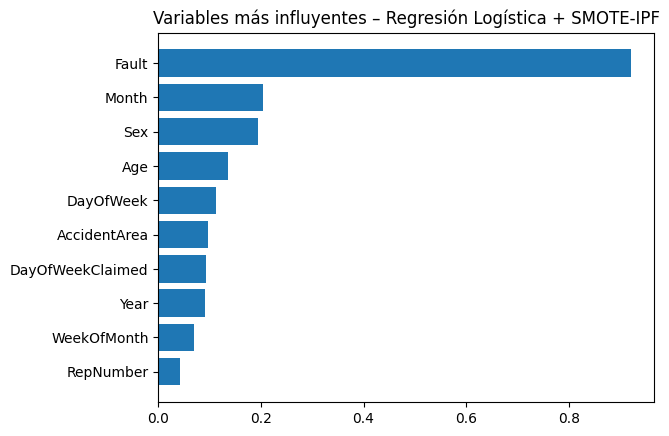

In [ ]:
import matplotlib.pyplot as plt

top10 = coef_df.head(10)

plt.figure()
plt.barh(top10['Variable'], top10['Importancia'])
plt.gca().invert_yaxis()
plt.title('Variables más influyentes – Regresión Logística + SMOTE-IPF')
plt.show()
